In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
#os.environ["CUDA_VISIBLE_DEVICES"]="1";  

from skimage.io import imread, imshow, imsave
from skimage.transform import resize, rotate
import matplotlib.pyplot as plt
import numpy as np
import os
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import random
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import shutil
from sklearn.utils import shuffle
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, JpegCompression
)
import cv2


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
from keras import Model
from keras.utils.training_utils import multi_gpu_model
class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
           serial-model holds references to the weights in the multi-gpu model.
           '''
        if 'load' in attrname or 'save' in attrname:
           return getattr(self._smodel, attrname)
        else:
           #return Model.__getattribute__(self, attrname)
           return super(ModelMGPU, self).__getattribute__(attrname)

In [3]:
image_dir = '/home/neuralbee/workspace/anti_spoof_detection/data/idrnd_train_data_v1/train/'

In [3]:
image_dir = '/home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/'

In [7]:
image_dir = '/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/'

In [3]:
image_dir = '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/'

In [3]:
BATCH_SIZE = 2
img_rows = 400
img_cols = 400
nb_classes = 2

In [5]:
dir1 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/data_by_persons_v1/'
dir2 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/data_by_persons_v2/'
dir3 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/data_by_persons_v3/'
dir5 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/data_by_persons_v5/'
dir6 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/data_by_persons_v6/'

In [5]:
dir_overall = '/home/neuralbee/workspace/anti_spoof_detection/our_data/overall/'

In [6]:
persons = list(set(os.listdir(dir_overall)))

In [6]:
persons = list(set(os.listdir(dir1) + os.listdir(dir2)+os.listdir(dir3)+os.listdir(dir5)+os.listdir(dir6)))

In [7]:
persons_train, persons_test = train_test_split(persons, test_size=0.33, random_state=42)

In [8]:
persons

['StepaGrigorev',
 'AndrejNegorozhin',
 'LevanKiknadze',
 'ViktorChernov',
 'MaksOgulov',
 'IgorBachenin',
 'AlbertUzdenov',
 'SashaZheleznjak',
 'ArtemSurma',
 'RomaEfremov',
 'VitjaChernov',
 'LeshaEvdokimov',
 'AleskejShvachkin',
 'StasSokirko',
 'KoljaZimin',
 'RenatKim',
 'DimaBratkov',
 'SemenDikanskij',
 'JuraKazakov',
 'LeshaMakarenko',
 'OlegSvekolnikov',
 'AleksandrZheleznjak',
 'MishaGladskoj',
 'ZhenjaTumanov',
 'IljaPshenichnyj',
 'LeshaShvachkin',
 'AleksejMakarenko',
 'StepanGrigorev',
 'MaksimOgulov',
 'Denis',
 'KostjaTkachenko',
 'VladSemenov',
 'DenisGubanov',
 'SashaAnanev']

In [9]:
persons_test

['RenatKim',
 'LeshaMakarenko',
 'StepanGrigorev',
 'AleksejMakarenko',
 'ArtemSurma',
 'IljaPshenichnyj',
 'AleksandrZheleznjak',
 'AleskejShvachkin',
 'DenisGubanov',
 'RomaEfremov',
 'StepaGrigorev',
 'MaksOgulov']

In [10]:
X_train = []
X_test = []
y_train = []
y_test = []

In [11]:
for person in persons_train:
    if person in os.listdir(dir_overall):
        c = 0
        #for cls in ['real/',  'printed-color/']:#, 'printed-color-cut/']:
        for cls in ['real/', 'printed/', 'printed-color/', 'printed-color-cut/' , 'replay/']:
            path = dir_overall + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.png')
            y_train = y_train + len(glob.glob(path+'/*.png'))*[c]
            c = 1
            

for person in persons_test:
    if person in os.listdir(dir_overall):
        c = 0
        for cls in ['real/', 'printed/', 'printed-color/', 'printed-color-cut/','replay/']:
            path = dir_overall + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.png')
            y_test = y_test + len(glob.glob(path+'/*.png'))*[c]
            c = 1
   

In [29]:
import matplotlib.pyplot as plt

1
/home/neuralbee/workspace/anti_spoof_detection/our_data/overall_crop_png//DimaBratkov/printed/869_printed__008__DimaBratkov__placebo_trim.png


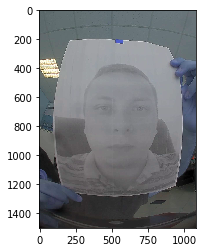

In [44]:
tmp = 24
print(y_train[tmp])
print(X_train[tmp])
plt.imshow(cv2.imread(X_train[tmp]))

In [38]:
img = cv2.imread(X_train[tmp])
print(img.shape)

(441, 619, 3)


In [11]:
X_train_new = []
y_train_new = []
for i,x in enumerate(X_train):
    
    img = cv2.imread(x)
    #if img.shape[0] > img.shape[1]:
    #    print(i, x)
    #    print(img.shape)
    if img.shape[1]/img.shape[0] > 1.35 and  img.shape[1]/img.shape[0] < 1.45:
        print(img.shape)
        X_train_new.append(X_train[i])
        y_train_new.append(y_train[i])

(530, 744, 3)
(530, 744, 3)
(441, 619, 3)
(441, 619, 3)
(367, 515, 3)
(441, 619, 3)
(530, 744, 3)
(367, 515, 3)
(304, 432, 3)
(304, 432, 3)
(530, 744, 3)
(367, 515, 3)
(367, 515, 3)
(530, 744, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(304, 432, 3)
(441, 619, 3)
(763, 1046, 3)
(530, 744, 3)
(367, 515, 3)
(367, 515, 3)
(632, 891, 3)
(441, 619, 3)
(367, 515, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(760, 1046, 3)
(760, 1046, 3)
(635, 891, 3)
(635, 891, 3)
(527, 744, 3)
(635, 891, 3)
(760, 1046, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(527, 744, 3)
(176, 248, 3)
(530, 744, 3)
(635, 891, 3)
(367, 515, 3)
(763, 1046, 3)
(635, 891, 3)
(635, 891, 3)
(367, 515, 3)
(441, 619, 3)
(441, 619, 3)
(441, 616, 3)
(635, 891, 3)
(635, 891, 3)
(530, 744, 3)
(635, 891, 3)
(441, 619, 3)
(530, 739, 3)
(635, 891, 3)
(441, 619, 3)
(441, 619, 3)
(632, 891, 3)
(530, 744, 3)
(527, 744, 3)
(530, 739, 3)
(530, 739, 3)
(527, 744, 3)
(527, 744, 3)
(

(304, 432, 3)
(304, 432, 3)
(304, 432, 3)
(367, 515, 3)
(530, 744, 3)
(530, 739, 3)
(438, 619, 3)
(530, 739, 3)
(530, 744, 3)
(438, 619, 3)
(530, 744, 3)
(527, 739, 3)
(438, 619, 3)
(530, 744, 3)
(530, 744, 3)
(438, 619, 3)
(635, 891, 3)
(438, 619, 3)
(530, 739, 3)


In [12]:
X_test_new = []
y_test_new = []
for i,x in enumerate(X_test):
    img = cv2.imread(x)
    if img.shape[1]/img.shape[0] > 1.35 and  img.shape[1]/img.shape[0] < 1.45:
        print(img.shape)
        X_test_new.append(X_test[i])
        y_test_new.append(y_test[i])

(530, 744, 3)
(530, 744, 3)
(635, 891, 3)
(635, 891, 3)
(530, 744, 3)
(763, 1044, 3)
(635, 891, 3)
(760, 1044, 3)
(635, 891, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(441, 619, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(367, 515, 3)
(635, 891, 3)
(635, 891, 3)
(441, 619, 3)
(441, 619, 3)
(632, 891, 3)
(632, 891, 3)
(527, 744, 3)
(530, 739, 3)
(527, 744, 3)
(527, 744, 3)
(635, 891, 3)
(441, 619, 3)
(441, 619, 3)
(527, 744, 3)
(530, 744, 3)
(763, 1067, 3)
(635, 891, 3)
(635, 891, 3)
(763, 1046, 3)
(635, 891, 3)
(256, 355, 3)
(304, 432, 3)
(530, 744, 3)
(530, 744, 3)
(635, 891, 3)
(530, 744, 3)
(530, 744, 3)
(438, 619, 3)
(527, 739, 3)
(530, 739, 3)
(530, 744, 3)
(530, 739, 3)
(530, 744, 3)
(530, 744, 3)
(527, 739, 3)
(635, 891, 3)
(441, 619, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(763, 1044, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(635, 891, 3)
(530, 744, 3)
(441, 619, 3)
(441, 616, 3)
(527, 744, 3)
(

In [13]:
len(X_test)

421

In [14]:
X_train = X_train_new
X_test = X_test_new
y_train = y_train_new
y_test = y_test_new

In [11]:
for person in persons_train:
    if person in os.listdir(dir1):
        c = 0
        for cls in ['real/', 'printed/', 'replay/']:
            path = dir1 + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.jpg')
            y_train = y_train + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir2):
        c = 0
        for cls in ['real/', 'printed/', 'replay/']:
            path = dir2 + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.jpg')
            y_train = y_train + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir3):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir3 + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.jpg')
            y_train = y_train + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir5):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir5 + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.jpg')
            y_train = y_train + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir6):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir6 + person +'/'+cls
            X_train = X_train + glob.glob(path+'/*.jpg')
            y_train = y_train + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1

for person in persons_test:
    if person in os.listdir(dir1):
        c = 0
        for cls in ['real/', 'printed/', 'replay/']:
            path = dir1 + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.jpg')
            y_test = y_test + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir2):
        c = 0
        for cls in ['real/', 'printed/', 'replay/']:
            path = dir2 + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.jpg')
            y_test = y_test + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir3):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir3 + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.jpg')
            y_test = y_test + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir5):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir5 + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.jpg')
            y_test = y_test + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1
    if person in os.listdir(dir6):
        c = 0
        for cls in ['real/', 'printed-color/']:#, 'printed-color-cut/']:
            path = dir6 + person +'/'+cls
            X_test = X_test + glob.glob(path+'/*.jpg')
            y_test = y_test + len(glob.glob(path+'/*.jpg'))*[c]
            c = 1

In [16]:
a = np.array(y_test)
len(a[a==0])

241

In [17]:
len(y_test)

568

In [10]:
real_list = glob.glob(os.path.join(image_dir, 'real/*'))
printed_list = glob.glob(os.path.join(image_dir, 'printed/*'))
replay_list = glob.glob(os.path.join(image_dir, 'replay/*'))

NameError: name 'image_dir' is not defined

In [6]:
train_real_filelist = glob.glob(os.path.join(image_dir, 'real/*.jpg'))
train_spoof_filelist = glob.glob(os.path.join(image_dir, 'spoof/*.jpg'))
train_filelist = train_real_filelist + train_spoof_filelist
train_labels = [0] * len(train_real_filelist) + [1] * len(train_spoof_filelist)
X_train = train_filelist
y_train = train_labels

In [8]:
train_real_filelist = glob.glob(os.path.join(image_dir, 'real/*.jpg'))
train_spoof_filelist = glob.glob(os.path.join(image_dir, 'spoof/*.jpg'))
train_filelist = train_real_filelist + train_spoof_filelist
train_labels = [0] * len(train_real_filelist) + [1] * len(train_spoof_filelist)
X_test = train_filelist
y_test = train_labels

In [5]:
real_list = glob.glob(os.path.join(image_dir, 'real/real*/*.png'))
printed_list = glob.glob(os.path.join(image_dir, 'printed/printed*/*.png'))
replay_list = glob.glob(os.path.join(image_dir, 'replay/replay*/*.png'))
mask_list = glob.glob(os.path.join(image_dir, '2dmask/2dmask*/*.png'))

In [5]:
real_list = glob.glob(os.path.join(image_dir, 'real/*'))
printed_list = glob.glob(os.path.join(image_dir, 'printed/*'))
replay_list = glob.glob(os.path.join(image_dir, 'replay/*'))
#mask_list = glob.glob(os.path.join(image_dir, '2dmask/2dmask*'))

In [14]:
train_filelist = real_list + printed_list + replay_list + mask_list
train_all_labels = [0]*len(real_list) + [1]*len(printed_list) + [2]*len(replay_list) + [3]*len(mask_list)

In [6]:
train_filelist = real_list + printed_list + replay_list
train_all_labels = [0]*len(real_list) + [1]*len(printed_list) + [2]*len(replay_list)

In [7]:
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(train_filelist, train_all_labels, test_size=0.4, random_state=32, stratify=train_all_labels)

In [8]:
X_test_id

['/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/real/лёша швачкин',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/replay/миша гладской',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/printed/витя чернов',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/real/миша гладской',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/printed/лёша швачкин',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/printed/дима братков',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/real/женя туманов',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/printed/миша гладской',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/replay/витя чернов',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/replay/игорь баченин',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/videos/real/влад семёнов',
 '/home/neuralbee/workspace/anti_spoof_detect

In [9]:
X_train = []
X_test = []
y_train = []
y_test = []
for i, x in enumerate(X_train_id):
    X_train = X_train + glob.glob(x+'/*.jpg')
    c = 1
    if y_train_id[i] == 0:
        c = 0
    y_train = y_train + len(glob.glob(x+'/*.jpg'))*[c]

In [10]:
for i, x in enumerate(X_test_id):
    X_test = X_test + glob.glob(x+'/*.jpg')
    c = 1
    if y_test_id[i] == 0:
        c = 0

    y_test = y_test + len(glob.glob(x+'/*.jpg'))*[c]

In [6]:
train_filelist = real_list + printed_list + replay_list + mask_list
train_labels = [0]*len(real_list) + [1]*len(printed_list) + [1]*len(replay_list) + [1]*len(mask_list)
train_all_labels = [0]*len(real_list) + [1]*len(printed_list) + [2]*len(replay_list) + [3]*len(mask_list)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_filelist, train_labels, test_size=0.2, random_state=42, stratify=train_all_labels)

In [13]:
len(X_test)

2281

In [14]:
len(X_train)

4254

In [11]:
def test_generator(x, batch_size=64):
    num_samples = len(x)#x.shape[0]
    while 1:
        for i in range(0, num_samples, batch_size):
            x_data = [preprocess_image(im) for im in x[i:i + batch_size]]
            yield np.array(x_data)


def train_generator(x, y, batch_size=64):
    num_samples = len(x)#x.shape[0]
    while 1:
        try:
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_and_aug_image(im) for im in x[i:i + batch_size]]
                y_data = y[i:i + batch_size]

                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            xxx = 1
            #print(err)
            
def val_generator(x, y, batch_size=64):
    num_samples = len(x)#x.shape[0]
    while 1:
        try:
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_image(im) for im in x[i:i + batch_size]]
                y_data = y[i:i + batch_size]

                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            xxx = 1
            #print(err)

            
def face_aug(p=.5):
    return Compose([
        HorizontalFlip(p=0.5),
        OneOf([
            IAAAdditiveGaussianNoise(scale=(1, 3)),
            GaussNoise(var_limit=(1, 5)),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(alpha=(0.1, 0.2)),
            IAAEmboss(strength=(0.1, 0.3)),
            RandomContrast(limit=0.1),
            RandomBrightness(limit=0.15),
        ], p=0.3)
    ], p=p)

def weak_aug(p=.5):
    return Compose([
        HorizontalFlip(p=0.5),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.3),
    ], p=p)

def strong_aug(p=.5):
    return Compose([
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)


def augmentation(image):
    aug = strong_aug(p=1)
    image = aug(image=image)['image']
    return image

def preprocess_and_aug_image(image_path, size=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (size, size))
    img = augmentation(img)
    img = img/255.0
    return img

def preprocess_image(image_path, size=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (size, size))
    img = img/255.0
    return img

train_generator = train_generator(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = val_generator(X_test, y_test, batch_size=BATCH_SIZE)

In [12]:
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model

from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    trs = np.linspace(0,0.5)
    recallm =  K.cast(0, y_pred.dtype)
    for threshold in trs:
        #P(falsealarm) + 19⋅P(miss), что равно FP/(FP+TN) + 19⋅FN/(FN+TP).
        threshold = K.cast(threshold, y_pred.dtype)
        y_pred_t = K.cast(y_pred > threshold, y_pred.dtype)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred_t, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recallm = K.maximum(recall, recallm)
    return recallm

def minC(y_true, y_pred):
    trs = np.linspace(0,0.5)
    minCm =  K.cast(1000.0, y_pred.dtype)
    for threshold in trs:
        #P(falsealarm) + 19⋅P(miss), что равно FP/(FP+TN) + 19⋅FN/(FN+TP).
        threshold = K.cast(threshold, y_pred.dtype)
        y_pred_t = K.cast(y_pred > threshold, y_pred.dtype)
        FP = K.sum(K.round(K.clip((1-y_true) * y_pred_t, 0, 1)))
        TP = K.sum(K.round(K.clip(y_true * y_pred_t, 0, 1)))
        FN = K.sum(K.round(K.clip(y_true * (1-y_pred_t), 0, 1)))
        TN = K.sum(K.round(K.clip((1-y_true) * (1-y_pred_t), 0, 1)))
        minC = FP/(FP+TN+ K.epsilon()) + 19*FN/(FN+TP+ K.epsilon())
        minCm = K.minimum(minC, minCm)
            
    return minCm

  
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [12]:
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model

from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def minC(y_true, y_pred):
    #P(falsealarm) + 19⋅P(miss), что равно FP/(FP+TN) + 19⋅FN/(FN+TP).    
    FP = K.sum(K.round(K.clip((1-y_true) * y_pred, 0, 1)))
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    FN = K.sum(K.round(K.clip(y_true * (1-y_pred), 0, 1)))
    TN = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    minC = FP/(FP+TN+ K.epsilon()) + 19*FN/(FN+TP+ K.epsilon())
    return minC
  
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [13]:
data_size_train = 400
data_size_test = 400
train = pd.DataFrame()
train['path'] = X_train#[:data_size_train] + X_train[-data_size_train:]
train['label'] = y_train#[:data_size_train] + y_train[-data_size_train:]
test = pd.DataFrame()
test['path'] = X_test#[:data_size_test] + X_test[-data_size_test:]
test['label'] = y_test#[:data_size_test] + y_test[-data_size_test:]


In [14]:
train['label'] = train['label'].astype('str')
test['label'] = test['label'].astype('str')

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255, fill_mode = 'nearest')
train_datagen = ImageDataGenerator(rescale=1./255, fill_mode = 'nearest', horizontal_flip=True, zoom_range=0.15)
#train_datagen = ImageDataGenerator(rescale=1./255, fill_mode = 'nearest')

In [15]:
train_gen = train_datagen.flow_from_dataframe(
    train, directory=None, x_col='path', 
    y_col='label', target_size=(img_rows, img_cols), 
    color_mode='rgb', 
    classes=None, 
    class_mode='binary', 
    batch_size=BATCH_SIZE, 
    interpolation='nearest', 
    drop_duplicates=True)

val_gen = test_datagen.flow_from_dataframe(
    test, directory=None, x_col='path', 
    y_col='label', target_size=(img_rows, img_cols),
    color_mode='rgb', 
    classes=None, 
    class_mode='binary', 
    batch_size=BATCH_SIZE, 
    interpolation='nearest', 
    drop_duplicates=True, shuffle=False) 

Found 6600 images belonging to 2 classes.
Found 2640 images belonging to 2 classes.


In [16]:
model_final.load_weights('./DensNet121.h5')

In [17]:
from keras.applications import DenseNet201
model = DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_rows, img_cols, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(2048, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
x = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
# img_test = cv2.imread('./our_data/images/real/100_angle-dima-1-close.jpg')
# img = augmentation(img_test)
# plt.imshow(img)

In [16]:
from keras.applications import DenseNet121, DenseNet201, MobileNetV2
model = DenseNet121(weights = "imagenet", include_top=False, input_shape = (img_rows, img_cols, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = Flatten()(x)

#x = Dense(100, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#x = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
#x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
#predictions = Dense(1, activation="sigmoid")(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [17]:
model_final = ModelMGPU(model_final, 2)

In [18]:
model_final.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0000001, decay=0.0001), metrics=['accuracy',auc,f1, recall, minC])

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

weight_path='DenseNet121_test.h5'
#weight_path='DenseNet121_no_d9_d6_d13_onlya4_20frames_0.3test_1e-7lr_400x400.h5'
#weight_path='DensNet201_d2_d8_d9_d10_d11_d12_50_frames_0.3test_1e-7lr_400x400.h5'
#weight_path='DensNet121_test.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_minC', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='min', min_lr=0.0000001)

def exp_decay(epoch):
    initial_lrate = 0.0001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
  
callbacks_list = [checkpoint, reduceLROnPlat]

In [20]:
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [21]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
3300/3300 [==============================] - 664s 201ms/step - loss: 0.5605 - acc: 0.7127 - auc: 0.6507 - f1: 0.7322 - recall: 0.9236 - minC: 0.3277 - val_loss: 0.5699 - val_acc: 0.7227 - val_auc: 0.7057 - val_f1: 0.6669 - val_recall: 0.7348 - val_minC: 0.1864

Epoch 00001: val_minC improved from inf to 0.18636, saving model to DenseNet121_test.h5
Epoch 2/100
3300/3300 [==============================] - 520s 158ms/step - loss: 0.3979 - acc: 0.8209 - auc: 0.7443 - f1: 0.8101 - recall: 0.9179 - minC: 0.2303 - val_loss: 0.4950 - val_acc: 0.7580 - val_auc: 0.7775 - val_f1: 0.6806 - val_recall: 0.7348 - val_minC: 0.1682

Epoch 00002: val_minC improved from 0.18636 to 0.16818, saving model to DenseNet121_test.h5
Epoch 3/100
3300/3300 [==============================] - 481s 146ms/step - loss: 0.3057 - acc: 0.8832 - auc: 0.8036 - f1: 0.8520 - recall: 0.9212 - minC: 0.1580 - val_loss: 0.4366 - val_acc: 0.7996 - val_auc: 0.8266 - val_f1: 0.6937 - val_recall: 0.7348 - val_minC: 0.1439

3300/3300 [==============================] - 474s 144ms/step - loss: 0.0358 - acc: 0.9977 - auc: 0.9806 - f1: 0.9175 - recall: 0.9185 - minC: 0.0038 - val_loss: 0.1975 - val_acc: 0.9303 - val_auc: 0.9811 - val_f1: 0.7260 - val_recall: 0.7348 - val_minC: 0.0572

Epoch 00024: val_minC improved from 0.06402 to 0.05720, saving model to DenseNet121_test.h5
Epoch 25/100
3300/3300 [==============================] - 472s 143ms/step - loss: 0.0340 - acc: 0.9979 - auc: 0.9816 - f1: 0.9220 - recall: 0.9233 - minC: 0.0038 - val_loss: 0.1990 - val_acc: 0.9273 - val_auc: 0.9820 - val_f1: 0.7285 - val_recall: 0.7348 - val_minC: 0.0636

Epoch 00025: val_minC did not improve from 0.05720
Epoch 26/100
3300/3300 [==============================] - 474s 144ms/step - loss: 0.0326 - acc: 0.9980 - auc: 0.9824 - f1: 0.9178 - recall: 0.9185 - minC: 0.0030 - val_loss: 0.1960 - val_acc: 0.9280 - val_auc: 0.9828 - val_f1: 0.7280 - val_recall: 0.7348 - val_minC: 0.0621

Epoch 00026: val_minC did not improve from 0.

3300/3300 [==============================] - 475s 144ms/step - loss: 0.0173 - acc: 0.9989 - auc: 0.9916 - f1: 0.9201 - recall: 0.9206 - minC: 0.0018 - val_loss: 0.1595 - val_acc: 0.9405 - val_auc: 0.9917 - val_f1: 0.7290 - val_recall: 0.7348 - val_minC: 0.0511

Epoch 00048: val_minC did not improve from 0.04848
Epoch 49/100
3300/3300 [==============================] - 476s 144ms/step - loss: 0.0174 - acc: 0.9991 - auc: 0.9918 - f1: 0.9225 - recall: 0.9230 - minC: 0.0017 - val_loss: 0.1604 - val_acc: 0.9398 - val_auc: 0.9919 - val_f1: 0.7293 - val_recall: 0.7348 - val_minC: 0.0523

Epoch 00049: val_minC did not improve from 0.04848
Epoch 50/100
3300/3300 [==============================] - 475s 144ms/step - loss: 0.0172 - acc: 0.9986 - auc: 0.9920 - f1: 0.9161 - recall: 0.9167 - minC: 0.0023 - val_loss: 0.1600 - val_acc: 0.9409 - val_auc: 0.9920 - val_f1: 0.7295 - val_recall: 0.7348 - val_minC: 0.0515

Epoch 00050: val_minC did not improve from 0.04848
Epoch 51/100
3300/3300 [===========

3300/3300 [==============================] - 471s 143ms/step - loss: 0.0123 - acc: 0.9991 - auc: 0.9947 - f1: 0.9192 - recall: 0.9197 - minC: 0.0017 - val_loss: 0.1449 - val_acc: 0.9455 - val_auc: 0.9947 - val_f1: 0.7293 - val_recall: 0.7348 - val_minC: 0.0466

Epoch 00072: val_minC did not improve from 0.04470
Epoch 73/100
3300/3300 [==============================] - 473s 143ms/step - loss: 0.0120 - acc: 0.9991 - auc: 0.9947 - f1: 0.9211 - recall: 0.9215 - minC: 0.0015 - val_loss: 0.1461 - val_acc: 0.9455 - val_auc: 0.9948 - val_f1: 0.7293 - val_recall: 0.7348 - val_minC: 0.0466

Epoch 00073: val_minC did not improve from 0.04470
Epoch 74/100
3300/3300 [==============================] - 472s 143ms/step - loss: 0.0119 - acc: 0.9992 - auc: 0.9948 - f1: 0.9184 - recall: 0.9188 - minC: 0.0014 - val_loss: 0.1414 - val_acc: 0.9477 - val_auc: 0.9948 - val_f1: 0.7290 - val_recall: 0.7348 - val_minC: 0.0439

Epoch 00074: val_minC improved from 0.04470 to 0.04394, saving model to DenseNet121_te


Epoch 00095: val_minC did not improve from 0.04129

Epoch 00095: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 96/100
3300/3300 [==============================] - 472s 143ms/step - loss: 0.0096 - acc: 0.9995 - auc: 0.9961 - f1: 0.9177 - recall: 0.9179 - minC: 7.5758e-04 - val_loss: 0.1359 - val_acc: 0.9492 - val_auc: 0.9961 - val_f1: 0.7301 - val_recall: 0.7348 - val_minC: 0.0439

Epoch 00096: val_minC did not improve from 0.04129
Epoch 97/100
3300/3300 [==============================] - 473s 143ms/step - loss: 0.0095 - acc: 0.9998 - auc: 0.9961 - f1: 0.9217 - recall: 0.9218 - minC: 3.0303e-04 - val_loss: 0.1358 - val_acc: 0.9508 - val_auc: 0.9961 - val_f1: 0.7303 - val_recall: 0.7348 - val_minC: 0.0428

Epoch 00097: val_minC did not improve from 0.04129
Epoch 98/100
3300/3300 [==============================] - 473s 143ms/step - loss: 0.0094 - acc: 0.9994 - auc: 0.9961 - f1: 0.9170 - recall: 0.9173 - minC: 0.0011 - val_loss: 0.1359 - val_acc: 0.9481 - val_auc: 0.9962 - val_

Exception ignored in: <generator object my_gen at 0x7f0af8510b48>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f0a534e6620>
RuntimeError: generator ignored GeneratorExit


In [21]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
3170/3170 [==============================] - 501s 158ms/step - loss: 0.6101 - acc: 0.7158 - auc: 0.5808 - f1: 0.7494 - recall: 0.9309 - minC: 0.3462 - val_loss: 0.6556 - val_acc: 0.6434 - val_auc: 0.6630 - val_f1: 0.5547 - val_recall: 0.7172 - val_minC: 0.1531

Epoch 00001: val_minC improved from inf to 0.15310, saving model to DensNet121_no_d9_d6_d13_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 2/100
3170/3170 [==============================] - 472s 149ms/step - loss: 0.4477 - acc: 0.7924 - auc: 0.6929 - f1: 0.7953 - recall: 0.9218 - minC: 0.2607 - val_loss: 0.5389 - val_acc: 0.7097 - val_auc: 0.7305 - val_f1: 0.5922 - val_recall: 0.7172 - val_minC: 0.1293

Epoch 00002: val_minC improved from 0.15310 to 0.12931, saving model to DensNet121_no_d9_d6_d13_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 3/100
3170/3170 [==============================] - 468s 148ms/step - loss: 0.3499 - acc: 0.8546 - auc: 0.7543 - f1: 0.8392 - recall: 0.9249 - minC: 0.2000 - val_loss: 0.4861 - val_acc: 0

3170/3170 [==============================] - 468s 148ms/step - loss: 0.0596 - acc: 0.9937 - auc: 0.9663 - f1: 0.9236 - recall: 0.9265 - minC: 0.0104 - val_loss: 0.2151 - val_acc: 0.9076 - val_auc: 0.9673 - val_f1: 0.6860 - val_recall: 0.7172 - val_minC: 0.0490

Epoch 00022: val_minC did not improve from 0.04793
Epoch 23/100
3170/3170 [==============================] - 469s 148ms/step - loss: 0.0588 - acc: 0.9938 - auc: 0.9681 - f1: 0.9217 - recall: 0.9252 - minC: 0.0096 - val_loss: 0.2062 - val_acc: 0.9148 - val_auc: 0.9690 - val_f1: 0.6855 - val_recall: 0.7172 - val_minC: 0.0414

Epoch 00023: val_minC improved from 0.04793 to 0.04138, saving model to DensNet121_no_d9_d6_d13_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 24/100
3170/3170 [==============================] - 468s 148ms/step - loss: 0.0557 - acc: 0.9954 - auc: 0.9698 - f1: 0.9198 - recall: 0.9221 - minC: 0.0077 - val_loss: 0.2028 - val_acc: 0.9134 - val_auc: 0.9706 - val_f1: 0.6853 - val_recall: 0.7172 - val_minC: 0.0428

Epoch


Epoch 00045: val_minC did not improve from 0.03172
Epoch 46/100
3170/3170 [==============================] - 467s 147ms/step - loss: 0.0299 - acc: 0.9979 - auc: 0.9868 - f1: 0.9294 - recall: 0.9306 - minC: 0.0032 - val_loss: 0.1523 - val_acc: 0.9407 - val_auc: 0.9870 - val_f1: 0.6984 - val_recall: 0.7172 - val_minC: 0.0328

Epoch 00046: val_minC did not improve from 0.03172
Epoch 47/100
3170/3170 [==============================] - 469s 148ms/step - loss: 0.0296 - acc: 0.9979 - auc: 0.9872 - f1: 0.9223 - recall: 0.9237 - minC: 0.0038 - val_loss: 0.1524 - val_acc: 0.9441 - val_auc: 0.9874 - val_f1: 0.6975 - val_recall: 0.7172 - val_minC: 0.0279

Epoch 00047: val_minC improved from 0.03172 to 0.02793, saving model to DensNet121_no_d9_d6_d13_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 48/100
3170/3170 [==============================] - 469s 148ms/step - loss: 0.0299 - acc: 0.9983 - auc: 0.9875 - f1: 0.9202 - recall: 0.9211 - minC: 0.0028 - val_loss: 0.1520 - val_acc: 0.9417 - val_auc: 0.987


Epoch 00069: val_minC did not improve from 0.02552
Epoch 70/100
3170/3170 [==============================] - 467s 147ms/step - loss: 0.0212 - acc: 0.9991 - auc: 0.9922 - f1: 0.9350 - recall: 0.9356 - minC: 0.0019 - val_loss: 0.1341 - val_acc: 0.9500 - val_auc: 0.9923 - val_f1: 0.7030 - val_recall: 0.7172 - val_minC: 0.0300

Epoch 00070: val_minC did not improve from 0.02552
Epoch 71/100
3170/3170 [==============================] - 469s 148ms/step - loss: 0.0214 - acc: 0.9987 - auc: 0.9923 - f1: 0.9193 - recall: 0.9199 - minC: 0.0021 - val_loss: 0.1327 - val_acc: 0.9524 - val_auc: 0.9924 - val_f1: 0.7009 - val_recall: 0.7172 - val_minC: 0.0245

Epoch 00071: val_minC improved from 0.02552 to 0.02448, saving model to DensNet121_no_d9_d6_d13_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 72/100
3170/3170 [==============================] - 468s 148ms/step - loss: 0.0211 - acc: 0.9989 - auc: 0.9925 - f1: 0.9209 - recall: 0.9215 - minC: 0.0019 - val_loss: 0.1327 - val_acc: 0.9486 - val_auc: 0.992


Epoch 00093: val_minC did not improve from 0.02000
Epoch 94/100
3170/3170 [==============================] - 467s 147ms/step - loss: 0.0166 - acc: 0.9991 - auc: 0.9945 - f1: 0.9282 - recall: 0.9287 - minC: 0.0017 - val_loss: 0.1248 - val_acc: 0.9548 - val_auc: 0.9945 - val_f1: 0.7030 - val_recall: 0.7172 - val_minC: 0.0252

Epoch 00094: val_minC did not improve from 0.02000

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 95/100
3170/3170 [==============================] - 470s 148ms/step - loss: 0.0168 - acc: 0.9992 - auc: 0.9946 - f1: 0.9259 - recall: 0.9262 - minC: 0.0013 - val_loss: 0.1221 - val_acc: 0.9559 - val_auc: 0.9946 - val_f1: 0.7039 - val_recall: 0.7172 - val_minC: 0.0255

Epoch 00095: val_minC did not improve from 0.02000
Epoch 96/100
3170/3170 [==============================] - 469s 148ms/step - loss: 0.0169 - acc: 0.9992 - auc: 0.9946 - f1: 0.9326 - recall: 0.9331 - minC: 0.0016 - val_loss: 0.1211 - val_acc: 0.9528 - val_auc: 0.9947 - val_f1: 0.70

Exception ignored in: <generator object my_gen at 0x7fdc0372ef68>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7fdc01fe8e60>
RuntimeError: generator ignored GeneratorExit


In [21]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
780/780 [==============================] - 145s 186ms/step - loss: 0.7641 - acc: 0.6737 - auc: 0.5959 - f1: 0.7363 - recall: 0.8962 - minC: 0.4987 - val_loss: 0.7898 - val_acc: 0.6292 - val_auc: 0.6002 - val_f1: 0.5667 - val_recall: 0.6667 - val_minC: 0.2444

Epoch 00001: val_minC improved from inf to 0.24444, saving model to DensNet121_d14_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 2/100
780/780 [==============================] - 116s 149ms/step - loss: 0.5025 - acc: 0.7423 - auc: 0.6264 - f1: 0.7338 - recall: 0.8795 - minC: 0.3282 - val_loss: 0.7009 - val_acc: 0.6306 - val_auc: 0.6579 - val_f1: 0.5593 - val_recall: 0.6667 - val_minC: 0.2333

Epoch 00002: val_minC improved from 0.24444 to 0.23333, saving model to DensNet121_d14_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 3/100
780/780 [==============================] - 117s 150ms/step - loss: 0.4032 - acc: 0.8224 - auc: 0.6836 - f1: 0.7850 - recall: 0.9026 - minC: 0.2244 - val_loss: 0.6323 - val_acc: 0.6556 - val_auc: 0.7084 

KeyboardInterrupt: 

In [28]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
334/334 [==============================] - 80s 241ms/step - loss: 0.8247 - acc: 0.5584 - auc: 0.5138 - f1: 0.5459 - recall: 0.8623 - minC: 0.4087 - val_loss: 0.8766 - val_acc: 0.5299 - val_auc: 0.5340 - val_f1: 0.4026 - val_recall: 0.5986 - val_minC: 0.2782

Epoch 00001: val_minC improved from inf to 0.27817, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 2/100
334/334 [==============================] - 51s 153ms/step - loss: 0.7608 - acc: 0.5943 - auc: 0.5483 - f1: 0.5669 - recall: 0.8623 - minC: 0.4057 - val_loss: 0.8429 - val_acc: 0.5511 - val_auc: 0.5601 - val_f1: 0.4038 - val_recall: 0.5986 - val_minC: 0.2553

Epoch 00002: val_minC improved from 0.27817 to 0.25528, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 3/100
334/334 [==============================] - 51s 154ms/step - loss: 0.6868 - acc: 0.6377 - auc: 0.5755 - f1: 0.6228 - recall: 0.8623 - minC: 0.3743 - 


Epoch 00022: val_minC improved from 0.14789 to 0.13556, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 23/100
334/334 [==============================] - 51s 152ms/step - loss: 0.2166 - acc: 0.9386 - auc: 0.8002 - f1: 0.8104 - recall: 0.8623 - minC: 0.0689 - val_loss: 0.5177 - val_acc: 0.7553 - val_auc: 0.8033 - val_f1: 0.5094 - val_recall: 0.5986 - val_minC: 0.1496

Epoch 00023: val_minC did not improve from 0.13556
Epoch 24/100
334/334 [==============================] - 51s 152ms/step - loss: 0.2156 - acc: 0.9341 - auc: 0.8063 - f1: 0.8124 - recall: 0.8533 - minC: 0.0674 - val_loss: 0.5046 - val_acc: 0.7553 - val_auc: 0.8093 - val_f1: 0.5094 - val_recall: 0.5986 - val_minC: 0.1479

Epoch 00024: val_minC did not improve from 0.13556
Epoch 25/100
334/334 [==============================] - 51s 153ms/step - loss: 0.2050 - acc: 0.9536 - auc: 0.8122 - f1: 0.8393 - recall: 0.8713 - minC: 0.0524 - val_loss: 0.4982 - val_acc: 0.7711 - val_


Epoch 00046: val_minC improved from 0.10211 to 0.10035, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 47/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0859 - acc: 0.9970 - auc: 0.8919 - f1: 0.8513 - recall: 0.8533 - minC: 0.0060 - val_loss: 0.3801 - val_acc: 0.8239 - val_auc: 0.8930 - val_f1: 0.5376 - val_recall: 0.5986 - val_minC: 0.1092

Epoch 00047: val_minC did not improve from 0.10035
Epoch 48/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0867 - acc: 0.9955 - auc: 0.8941 - f1: 0.8433 - recall: 0.8443 - minC: 0.0060 - val_loss: 0.3798 - val_acc: 0.8345 - val_auc: 0.8952 - val_f1: 0.5423 - val_recall: 0.5986 - val_minC: 0.1021

Epoch 00048: val_minC did not improve from 0.10035
Epoch 49/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0833 - acc: 0.9955 - auc: 0.8963 - f1: 0.8543 - recall: 0.8563 - minC: 0.0075 - val_loss: 0.3711 - val_acc: 0.8292 - val_


Epoch 00069: val_minC improved from 0.07746 to 0.07394, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 70/100
334/334 [==============================] - 51s 153ms/step - loss: 0.0467 - acc: 1.0000 - auc: 0.9284 - f1: 0.8683 - recall: 0.8683 - minC: 0.0000e+00 - val_loss: 0.3159 - val_acc: 0.8609 - val_auc: 0.9289 - val_f1: 0.5493 - val_recall: 0.5986 - val_minC: 0.0845

Epoch 00070: val_minC did not improve from 0.07394
Epoch 71/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0433 - acc: 1.0000 - auc: 0.9295 - f1: 0.8234 - recall: 0.8234 - minC: 0.0000e+00 - val_loss: 0.3193 - val_acc: 0.8592 - val_auc: 0.9300 - val_f1: 0.5493 - val_recall: 0.5986 - val_minC: 0.0863

Epoch 00071: val_minC did not improve from 0.07394
Epoch 72/100
334/334 [==============================] - 51s 153ms/step - loss: 0.0434 - acc: 1.0000 - auc: 0.9305 - f1: 0.8713 - recall: 0.8713 - minC: 0.0000e+00 - val_loss: 0.3122 - val_acc: 0


Epoch 00093: val_minC did not improve from 0.06514
Epoch 94/100
334/334 [==============================] - 51s 153ms/step - loss: 0.0247 - acc: 1.0000 - auc: 0.9481 - f1: 0.8683 - recall: 0.8683 - minC: 0.0000e+00 - val_loss: 0.2673 - val_acc: 0.8908 - val_auc: 0.9484 - val_f1: 0.5563 - val_recall: 0.5986 - val_minC: 0.0581

Epoch 00094: val_minC improved from 0.06514 to 0.05810, saving model to DensNet121_d2_d5_d8_d10_d11_d12_cropheadpng_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 95/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0258 - acc: 1.0000 - auc: 0.9487 - f1: 0.8563 - recall: 0.8563 - minC: 0.0000e+00 - val_loss: 0.2770 - val_acc: 0.8803 - val_auc: 0.9490 - val_f1: 0.5563 - val_recall: 0.5986 - val_minC: 0.0722

Epoch 00095: val_minC did not improve from 0.05810
Epoch 96/100
334/334 [==============================] - 51s 152ms/step - loss: 0.0256 - acc: 1.0000 - auc: 0.9493 - f1: 0.8533 - recall: 0.8533 - minC: 0.0000e+00 - val_loss: 0.2671 - val_acc: 0

Exception ignored in: <generator object my_gen at 0x7f74f56722b0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f718c604e60>
RuntimeError: generator ignored GeneratorExit


In [24]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
366/365 [==============================] - 80s 219ms/step - loss: 0.6785 - acc: 0.6462 - auc: 0.6294 - f1: 0.5975 - recall: 0.8306 - minC: 0.3730 - val_loss: 0.6931 - val_acc: 0.3966 - val_auc: 0.6474 - val_f1: 0.0000e+00 - val_recall: 0.6322 - val_minC: 0.0575

Epoch 00001: val_minC improved from inf to 0.05747, saving model to DensNet121_d2_d5_d8_d10_d11_d12_crophead_5_frames_0.3test_1e-7lr_400x400.h5
Epoch 2/100
366/365 [==============================] - 51s 139ms/step - loss: 0.6015 - acc: 0.6776 - auc: 0.6481 - f1: 0.6321 - recall: 0.8552 - minC: 0.3224 - val_loss: 0.6931 - val_acc: 0.3966 - val_auc: 0.6590 - val_f1: 0.0000e+00 - val_recall: 0.6322 - val_minC: 0.0575

Epoch 00002: val_minC did not improve from 0.05747
Epoch 3/100
366/365 [==============================] - 51s 140ms/step - loss: 0.5654 - acc: 0.7104 - auc: 0.6664 - f1: 0.6430 - recall: 0.8443 - minC: 0.2937 - val_loss: 0.6931 - val_acc: 0.3966 - val_auc: 0.6745 - val_f1: 0.0000e+00 - val_recall: 0.6322 


Epoch 00024: val_minC did not improve from 0.05747
Epoch 25/100
366/365 [==============================] - 53s 145ms/step - loss: 0.1724 - acc: 0.9672 - auc: 0.8540 - f1: 0.8106 - recall: 0.8333 - minC: 0.0301 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.8558 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00025: val_minC did not improve from 0.05747

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 26/100
366/365 [==============================] - 53s 145ms/step - loss: 0.1583 - acc: 0.9768 - auc: 0.8576 - f1: 0.8206 - recall: 0.8415 - minC: 0.0191 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.8593 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00026: val_minC did not improve from 0.05747
Epoch 27/100
366/365 [==============================] - 52s 142ms/step - loss: 0.1548 - acc: 0.9754 - auc: 0.8610 - f1: 0.8415 - recall: 0.8607 - minC: 0.0205 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.8626 - val_f1: 0.6130 - val_


Epoch 00048: val_minC did not improve from 0.05747
Epoch 49/100
366/365 [==============================] - 53s 144ms/step - loss: 0.0700 - acc: 0.9986 - auc: 0.9032 - f1: 0.8470 - recall: 0.8470 - minC: 0.0014 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9037 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00049: val_minC did not improve from 0.05747

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 50/100
366/365 [==============================] - 53s 144ms/step - loss: 0.0657 - acc: 1.0000 - auc: 0.9042 - f1: 0.8388 - recall: 0.8388 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9047 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00050: val_minC did not improve from 0.05747
Epoch 51/100
366/365 [==============================] - 53s 144ms/step - loss: 0.0661 - acc: 1.0000 - auc: 0.9053 - f1: 0.8470 - recall: 0.8470 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9057 - val_f1: 0.613

366/365 [==============================] - 51s 139ms/step - loss: 0.0373 - acc: 1.0000 - auc: 0.9195 - f1: 0.8279 - recall: 0.8279 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9197 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00072: val_minC did not improve from 0.05747
Epoch 73/100
366/365 [==============================] - 51s 139ms/step - loss: 0.0373 - acc: 0.9986 - auc: 0.9200 - f1: 0.8279 - recall: 0.8279 - minC: 0.0014 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9202 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00073: val_minC did not improve from 0.05747

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 74/100
366/365 [==============================] - 51s 139ms/step - loss: 0.0347 - acc: 1.0000 - auc: 0.9204 - f1: 0.8497 - recall: 0.8497 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9206 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00074: val_minC 


Epoch 00095: val_minC did not improve from 0.05747
Epoch 96/100
366/365 [==============================] - 51s 139ms/step - loss: 0.0215 - acc: 1.0000 - auc: 0.9275 - f1: 0.8361 - recall: 0.8361 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9277 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00096: val_minC did not improve from 0.05747
Epoch 97/100
366/365 [==============================] - 51s 139ms/step - loss: 0.0217 - acc: 1.0000 - auc: 0.9278 - f1: 0.8415 - recall: 0.8415 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9279 - val_f1: 0.6130 - val_recall: 0.6322 - val_minC: 0.4253

Epoch 00097: val_minC did not improve from 0.05747

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 98/100
366/365 [==============================] - 51s 139ms/step - loss: 0.0211 - acc: 1.0000 - auc: 0.9280 - f1: 0.8361 - recall: 0.8361 - minC: 0.0000e+00 - val_loss: 0.6931 - val_acc: 0.6034 - val_auc: 0.9281 - val_f1: 0

Exception ignored in: <generator object my_gen at 0x7fbb98980e60>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7fbba87cdd58>
RuntimeError: generator ignored GeneratorExit


In [32]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
2280/2280 [==============================] - 353s 155ms/step - loss: 0.7241 - acc: 0.6397 - auc: 0.4581 - f1: 0.6819 - recall: 0.9241 - minC: 0.3803 - val_loss: 0.7325 - val_acc: 0.6405 - val_auc: 0.5159 - val_f1: 0.6153 - val_recall: 0.7176 - val_minC: 0.2252

Epoch 00001: val_minC improved from inf to 0.22519, saving model to DensNet121_d2+d5+d8+d9+d10+d11_d12_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 2/100
2280/2280 [==============================] - 323s 142ms/step - loss: 0.5596 - acc: 0.7213 - auc: 0.5496 - f1: 0.7501 - recall: 0.9241 - minC: 0.3445 - val_loss: 0.6544 - val_acc: 0.6813 - val_auc: 0.5867 - val_f1: 0.6430 - val_recall: 0.7176 - val_minC: 0.2187

Epoch 00002: val_minC improved from 0.22519 to 0.21870, saving model to DensNet121_d2+d5+d8+d9+d10+d11_d12_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 3/100
2280/2280 [==============================] - 324s 142ms/step - loss: 0.4586 - acc: 0.7875 - auc: 0.6147 - f1: 0.7923 - recall: 0.9228 - minC: 0.2800 - val_los

Epoch 22/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0897 - acc: 0.9890 - auc: 0.9188 - f1: 0.9168 - recall: 0.9219 - minC: 0.0178 - val_loss: 0.3502 - val_acc: 0.8412 - val_auc: 0.9206 - val_f1: 0.6980 - val_recall: 0.7176 - val_minC: 0.1324

Epoch 00022: val_minC did not improve from 0.12824
Epoch 23/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0815 - acc: 0.9919 - auc: 0.9222 - f1: 0.9174 - recall: 0.9215 - minC: 0.0143 - val_loss: 0.3518 - val_acc: 0.8393 - val_auc: 0.9238 - val_f1: 0.7008 - val_recall: 0.7176 - val_minC: 0.1385

Epoch 00023: val_minC did not improve from 0.12824
Epoch 24/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0812 - acc: 0.9912 - auc: 0.9253 - f1: 0.9208 - recall: 0.9250 - minC: 0.0147 - val_loss: 0.3360 - val_acc: 0.8504 - val_auc: 0.9268 - val_f1: 0.6997 - val_recall: 0.7176 - val_minC: 0.1263

Epoch 00024: val_minC improved from 0.12824 to 0.12634, saving model to D

Epoch 45/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0441 - acc: 0.9971 - auc: 0.9597 - f1: 0.9194 - recall: 0.9206 - minC: 0.0046 - val_loss: 0.2834 - val_acc: 0.8756 - val_auc: 0.9602 - val_f1: 0.7031 - val_recall: 0.7176 - val_minC: 0.1057

Epoch 00045: val_minC improved from 0.10916 to 0.10573, saving model to DensNet121_d2+d5+d8+d9+d10+d11_d12_20_frames_0.3test_1e-7lr_400x400.h5
Epoch 46/100
2280/2280 [==============================] - 327s 143ms/step - loss: 0.0434 - acc: 0.9965 - auc: 0.9606 - f1: 0.9243 - recall: 0.9259 - minC: 0.0059 - val_loss: 0.2833 - val_acc: 0.8740 - val_auc: 0.9610 - val_f1: 0.7038 - val_recall: 0.7176 - val_minC: 0.1080

Epoch 00046: val_minC did not improve from 0.10573
Epoch 47/100
2280/2280 [==============================] - 327s 143ms/step - loss: 0.0429 - acc: 0.9961 - auc: 0.9614 - f1: 0.9184 - recall: 0.9202 - minC: 0.0066 - val_loss: 0.2868 - val_acc: 0.8714 - val_auc: 0.9618 - val_f1: 0.7031 - val_recall: 0.7176 -


Epoch 00067: val_minC did not improve from 0.10000
Epoch 68/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0302 - acc: 0.9971 - auc: 0.9729 - f1: 0.9178 - recall: 0.9193 - minC: 0.0050 - val_loss: 0.2612 - val_acc: 0.8813 - val_auc: 0.9731 - val_f1: 0.7056 - val_recall: 0.7176 - val_minC: 0.1027

Epoch 00068: val_minC did not improve from 0.10000
Epoch 69/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0294 - acc: 0.9978 - auc: 0.9732 - f1: 0.9257 - recall: 0.9272 - minC: 0.0044 - val_loss: 0.2610 - val_acc: 0.8836 - val_auc: 0.9734 - val_f1: 0.7061 - val_recall: 0.7176 - val_minC: 0.1015

Epoch 00069: val_minC did not improve from 0.10000
Epoch 70/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0308 - acc: 0.9969 - auc: 0.9736 - f1: 0.9288 - recall: 0.9303 - minC: 0.0053 - val_loss: 0.2593 - val_acc: 0.8836 - val_auc: 0.9738 - val_f1: 0.7051 - val_recall: 0.7176 - val_minC: 0.1004

Epoch 00070: val_minC

Epoch 91/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0236 - acc: 0.9985 - auc: 0.9793 - f1: 0.9251 - recall: 0.9259 - minC: 0.0026 - val_loss: 0.2461 - val_acc: 0.8912 - val_auc: 0.9794 - val_f1: 0.7056 - val_recall: 0.7176 - val_minC: 0.0931

Epoch 00091: val_minC did not improve from 0.08893

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 92/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0238 - acc: 0.9982 - auc: 0.9795 - f1: 0.9272 - recall: 0.9281 - minC: 0.0031 - val_loss: 0.2467 - val_acc: 0.8912 - val_auc: 0.9796 - val_f1: 0.7061 - val_recall: 0.7176 - val_minC: 0.0935

Epoch 00092: val_minC did not improve from 0.08893
Epoch 93/100
2280/2280 [==============================] - 326s 143ms/step - loss: 0.0227 - acc: 0.9985 - auc: 0.9797 - f1: 0.9265 - recall: 0.9272 - minC: 0.0026 - val_loss: 0.2414 - val_acc: 0.8939 - val_auc: 0.9798 - val_f1: 0.7066 - val_recall: 0.7176 - val_minC: 0.0920

Epoch 00

Exception ignored in: <generator object my_gen at 0x7ff13e531888>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7ff14ca2ef10>
RuntimeError: generator ignored GeneratorExit


In [33]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
1570/1570 [==============================] - 248s 158ms/step - loss: 0.6885 - acc: 0.6229 - auc: 0.5831 - f1: 0.5796 - recall: 0.8713 - minC: 0.3443 - val_loss: 0.8305 - val_acc: 0.5336 - val_auc: 0.6102 - val_f1: 0.4753 - val_recall: 0.6986 - val_minC: 0.2048

Epoch 00001: val_minC improved from inf to 0.20479, saving model to DensNet121_d2+d5+d8+d9+d10+d11_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 2/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.4897 - acc: 0.7675 - auc: 0.6477 - f1: 0.7081 - recall: 0.8675 - minC: 0.2621 - val_loss: 0.7275 - val_acc: 0.5932 - val_auc: 0.6788 - val_f1: 0.5169 - val_recall: 0.6986 - val_minC: 0.1884

Epoch 00002: val_minC improved from 0.20479 to 0.18836, saving model to DensNet121_d2+d5+d8+d9+d10+d11_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 3/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.3895 - acc: 0.8366 - auc: 0.7067 - f1: 0.7628 - recall: 0.8675 - minC: 0.1825 - v


Epoch 00021: val_minC did not improve from 0.05959
Epoch 22/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0517 - acc: 0.9952 - auc: 0.9571 - f1: 0.8609 - recall: 0.8624 - minC: 0.0064 - val_loss: 0.2561 - val_acc: 0.9041 - val_auc: 0.9582 - val_f1: 0.6740 - val_recall: 0.6986 - val_minC: 0.0603

Epoch 00022: val_minC did not improve from 0.05959
Epoch 23/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0486 - acc: 0.9965 - auc: 0.9594 - f1: 0.8541 - recall: 0.8554 - minC: 0.0048 - val_loss: 0.2577 - val_acc: 0.9021 - val_auc: 0.9604 - val_f1: 0.6699 - val_recall: 0.6986 - val_minC: 0.0562

Epoch 00023: val_minC improved from 0.05959 to 0.05616, saving model to DensNet121_d2+d5+d8+d9+d10+d11_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 24/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0464 - acc: 0.9968 - auc: 0.9615 - f1: 0.8658 - recall: 0.8675 - minC: 0.0045 - val_loss: 0.2505 - val_acc: 0.9103 - 


Epoch 00045: val_minC improved from 0.05068 to 0.05000, saving model to DensNet121_d2+d5+d8+d9+d10+d11_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 46/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0216 - acc: 0.9990 - auc: 0.9828 - f1: 0.8611 - recall: 0.8618 - minC: 0.0019 - val_loss: 0.1784 - val_acc: 0.9342 - val_auc: 0.9830 - val_f1: 0.6881 - val_recall: 0.6986 - val_minC: 0.0500

Epoch 00046: val_minC did not improve from 0.05000
Epoch 47/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0204 - acc: 0.9990 - auc: 0.9833 - f1: 0.8605 - recall: 0.8611 - minC: 0.0019 - val_loss: 0.1781 - val_acc: 0.9342 - val_auc: 0.9835 - val_f1: 0.6868 - val_recall: 0.6986 - val_minC: 0.0479

Epoch 00047: val_minC improved from 0.05000 to 0.04795, saving model to DensNet121_d2+d5+d8+d9+d10+d11_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 48/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0195 - acc: 0.9997 - a

1570/1570 [==============================] - 217s 138ms/step - loss: 0.0130 - acc: 1.0000 - auc: 0.9894 - f1: 0.8701 - recall: 0.8701 - minC: 0.0000e+00 - val_loss: 0.1519 - val_acc: 0.9438 - val_auc: 0.9895 - val_f1: 0.6904 - val_recall: 0.6986 - val_minC: 0.0438

Epoch 00068: val_minC did not improve from 0.04315
Epoch 69/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0129 - acc: 1.0000 - auc: 0.9896 - f1: 0.8611 - recall: 0.8611 - minC: 0.0000e+00 - val_loss: 0.1486 - val_acc: 0.9418 - val_auc: 0.9897 - val_f1: 0.6909 - val_recall: 0.6986 - val_minC: 0.0466

Epoch 00069: val_minC did not improve from 0.04315
Epoch 70/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0125 - acc: 1.0000 - auc: 0.9898 - f1: 0.8637 - recall: 0.8637 - minC: 0.0000e+00 - val_loss: 0.1440 - val_acc: 0.9486 - val_auc: 0.9899 - val_f1: 0.6954 - val_recall: 0.6986 - val_minC: 0.0466

Epoch 00070: val_minC did not improve from 0.04315
Epoch 71/100
1570/1570 

1570/1570 [==============================] - 217s 138ms/step - loss: 0.0091 - acc: 1.0000 - auc: 0.9927 - f1: 0.8688 - recall: 0.8688 - minC: 0.0000e+00 - val_loss: 0.1257 - val_acc: 0.9534 - val_auc: 0.9928 - val_f1: 0.6954 - val_recall: 0.6986 - val_minC: 0.0418

Epoch 00092: val_minC did not improve from 0.04041
Epoch 93/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0089 - acc: 1.0000 - auc: 0.9928 - f1: 0.8586 - recall: 0.8586 - minC: 0.0000e+00 - val_loss: 0.1257 - val_acc: 0.9548 - val_auc: 0.9929 - val_f1: 0.6968 - val_recall: 0.6986 - val_minC: 0.0425

Epoch 00093: val_minC did not improve from 0.04041
Epoch 94/100
1570/1570 [==============================] - 217s 138ms/step - loss: 0.0087 - acc: 1.0000 - auc: 0.9929 - f1: 0.8675 - recall: 0.8675 - minC: 0.0000e+00 - val_loss: 0.1245 - val_acc: 0.9534 - val_auc: 0.9930 - val_f1: 0.6945 - val_recall: 0.6986 - val_minC: 0.0404

Epoch 00094: val_minC did not improve from 0.04041
Epoch 95/100
1570/1570 

Exception ignored in: <generator object my_gen at 0x7f98738efc50>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f987990ed58>
RuntimeError: generator ignored GeneratorExit


In [24]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 100,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/100
1410/1410 [==============================] - 342s 242ms/step - loss: 0.6311 - acc: 0.6816 - auc: 0.6297 - f1: 0.6634 - recall: 0.9035 - minC: 0.3032 - val_loss: 0.6701 - val_acc: 0.6867 - val_auc: 0.7039 - val_f1: 0.6678 - val_recall: 0.8300 - val_minC: 0.3942

Epoch 00001: val_minC improved from inf to 0.39417, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_800x800.h5
Epoch 2/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.4066 - acc: 0.8195 - auc: 0.7407 - f1: 0.7761 - recall: 0.8936 - minC: 0.2099 - val_loss: 0.5299 - val_acc: 0.7775 - val_auc: 0.7814 - val_f1: 0.7161 - val_recall: 0.8400 - val_minC: 0.2775

Epoch 00002: val_minC improved from 0.39417 to 0.27750, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_800x800.h5
Epoch 3/100
1410/1410 [==============================] - 313s 222ms/step - loss: 0.3004 - acc: 0.8904 - auc: 0.8089 - f1: 0.8333 - recall: 0.9021 - minC: 0.1270 - val_loss: 0


Epoch 00022: val_minC did not improve from 0.14167
Epoch 23/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0255 - acc: 0.9972 - auc: 0.9811 - f1: 0.8957 - recall: 0.8979 - minC: 0.0046 - val_loss: 0.2020 - val_acc: 0.9025 - val_auc: 0.9817 - val_f1: 0.7894 - val_recall: 0.8450 - val_minC: 0.1417

Epoch 00023: val_minC improved from 0.14167 to 0.14167, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_800x800.h5
Epoch 24/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0236 - acc: 0.9986 - auc: 0.9821 - f1: 0.8969 - recall: 0.8972 - minC: 0.0018 - val_loss: 0.2085 - val_acc: 0.9025 - val_auc: 0.9826 - val_f1: 0.7950 - val_recall: 0.8450 - val_minC: 0.1400

Epoch 00024: val_minC improved from 0.14167 to 0.14000, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_800x800.h5
Epoch 25/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0232 - acc: 0.9979 - auc: 0.9830

1410/1410 [==============================] - 312s 221ms/step - loss: 0.0093 - acc: 1.0000 - auc: 0.9917 - f1: 0.9000 - recall: 0.9000 - minC: 0.0000e+00 - val_loss: 0.1735 - val_acc: 0.9083 - val_auc: 0.9918 - val_f1: 0.7906 - val_recall: 0.8333 - val_minC: 0.1208

Epoch 00045: val_minC did not improve from 0.11667
Epoch 46/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0089 - acc: 1.0000 - auc: 0.9919 - f1: 0.8965 - recall: 0.8965 - minC: 0.0000e+00 - val_loss: 0.1712 - val_acc: 0.9083 - val_auc: 0.9920 - val_f1: 0.7839 - val_recall: 0.8333 - val_minC: 0.1267

Epoch 00046: val_minC did not improve from 0.11667
Epoch 47/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0085 - acc: 1.0000 - auc: 0.9922 - f1: 0.8929 - recall: 0.8929 - minC: 0.0000e+00 - val_loss: 0.1785 - val_acc: 0.9075 - val_auc: 0.9923 - val_f1: 0.7950 - val_recall: 0.8450 - val_minC: 0.1300

Epoch 00047: val_minC did not improve from 0.11667

Epoch 00047: ReduceLRO


Epoch 00068: val_minC did not improve from 0.11333
Epoch 69/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0045 - acc: 1.0000 - auc: 0.9949 - f1: 0.9014 - recall: 0.9014 - minC: 0.0000e+00 - val_loss: 0.1626 - val_acc: 0.9117 - val_auc: 0.9950 - val_f1: 0.7939 - val_recall: 0.8467 - val_minC: 0.1275

Epoch 00069: val_minC did not improve from 0.11333
Epoch 70/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0044 - acc: 1.0000 - auc: 0.9950 - f1: 0.8929 - recall: 0.8929 - minC: 0.0000e+00 - val_loss: 0.1627 - val_acc: 0.9108 - val_auc: 0.9951 - val_f1: 0.8089 - val_recall: 0.8550 - val_minC: 0.1200

Epoch 00070: val_minC did not improve from 0.11333
Epoch 71/100
1410/1410 [==============================] - 311s 221ms/step - loss: 0.0043 - acc: 1.0000 - auc: 0.9951 - f1: 0.8957 - recall: 0.8957 - minC: 0.0000e+00 - val_loss: 0.1656 - val_acc: 0.9083 - val_auc: 0.9951 - val_f1: 0.7978 - val_recall: 0.8467 - val_minC: 0.1258

Epoch 000

1410/1410 [==============================] - 311s 221ms/step - loss: 0.0027 - acc: 1.0000 - auc: 0.9963 - f1: 0.8837 - recall: 0.8837 - minC: 0.0000e+00 - val_loss: 0.1631 - val_acc: 0.9075 - val_auc: 0.9963 - val_f1: 0.7894 - val_recall: 0.8400 - val_minC: 0.1250

Epoch 00092: val_minC did not improve from 0.10833
Epoch 93/100
1410/1410 [==============================] - 311s 221ms/step - loss: 0.0027 - acc: 1.0000 - auc: 0.9963 - f1: 0.8901 - recall: 0.8901 - minC: 0.0000e+00 - val_loss: 0.1612 - val_acc: 0.9117 - val_auc: 0.9963 - val_f1: 0.7756 - val_recall: 0.8200 - val_minC: 0.1158

Epoch 00093: val_minC did not improve from 0.10833
Epoch 94/100
1410/1410 [==============================] - 312s 221ms/step - loss: 0.0027 - acc: 1.0000 - auc: 0.9963 - f1: 0.8801 - recall: 0.8801 - minC: 0.0000e+00 - val_loss: 0.1572 - val_acc: 0.9133 - val_auc: 0.9964 - val_f1: 0.7861 - val_recall: 0.8317 - val_minC: 0.1167

Epoch 00094: val_minC did not improve from 0.10833

Epoch 00094: ReduceLRO

Exception ignored in: <generator object my_gen at 0x7fd03f9ef0a0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7fcc5ec02e08>
RuntimeError: generator ignored GeneratorExit


In [ ]:
pr

In [23]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 25,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/25
1400/1400 [==============================] - 224s 160ms/step - loss: 0.8045 - acc: 0.5686 - auc: 0.5700 - f1: 0.4560 - recall: 0.8671 - minC: 0.2918 - val_loss: 0.6679 - val_acc: 0.6573 - val_auc: 0.6189 - val_f1: 0.5731 - val_recall: 0.8823 - val_minC: 0.2129

Epoch 00001: val_minC improved from inf to 0.21290, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 2/25
1400/1400 [==============================] - 194s 139ms/step - loss: 0.5392 - acc: 0.7236 - auc: 0.6596 - f1: 0.6852 - recall: 0.8721 - minC: 0.2900 - val_loss: 0.5872 - val_acc: 0.7129 - val_auc: 0.6953 - val_f1: 0.6204 - val_recall: 0.8839 - val_minC: 0.1992

Epoch 00002: val_minC improved from 0.21290 to 0.19919, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 3/25
1400/1400 [==============================] - 195s 139ms/step - loss: 0.4375 - acc: 0.7979 - auc: 0.7232 - f1: 0.7464 - recall: 0.8779 - minC: 0.2239 - val_loss: 0.50


Epoch 00021: val_minC did not improve from 0.02016
Epoch 22/25
1400/1400 [==============================] - 195s 139ms/step - loss: 0.0743 - acc: 0.9854 - auc: 0.9652 - f1: 0.8655 - recall: 0.8736 - minC: 0.0196 - val_loss: 0.2057 - val_acc: 0.9258 - val_auc: 0.9662 - val_f1: 0.8011 - val_recall: 0.8806 - val_minC: 0.0185

Epoch 00022: val_minC improved from 0.02016 to 0.01855, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 23/25
1400/1400 [==============================] - 195s 139ms/step - loss: 0.0718 - acc: 0.9854 - auc: 0.9672 - f1: 0.8640 - recall: 0.8729 - minC: 0.0207 - val_loss: 0.2036 - val_acc: 0.9250 - val_auc: 0.9681 - val_f1: 0.8102 - val_recall: 0.8903 - val_minC: 0.0145

Epoch 00023: val_minC improved from 0.01855 to 0.01452, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames_no_cut_0.3test_1e-7lr_400x400.h5
Epoch 24/25
1400/1400 [==============================] - 195s 139ms/step - loss: 0.0706 - acc: 0.9839 - auc: 0.9689 - 

Exception ignored in: <generator object my_gen at 0x7ff487cfbfc0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7ff711431db0>
RuntimeError: generator ignored GeneratorExit


In [23]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 25,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/25
1670/1670 [==============================] - 263s 158ms/step - loss: 0.6397 - acc: 0.6997 - auc: 0.5568 - f1: 0.7367 - recall: 0.9335 - minC: 0.3437 - val_loss: 0.7279 - val_acc: 0.7029 - val_auc: 0.6158 - val_f1: 0.7259 - val_recall: 0.8953 - val_minC: 0.3600

Epoch 00001: val_minC improved from inf to 0.36000, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames__0.3test_1e-7lr_400x400.h5
Epoch 2/25
1670/1670 [==============================] - 233s 140ms/step - loss: 0.4732 - acc: 0.7844 - auc: 0.6485 - f1: 0.7986 - recall: 0.9287 - minC: 0.2808 - val_loss: 0.6479 - val_acc: 0.7306 - val_auc: 0.6778 - val_f1: 0.7353 - val_recall: 0.9000 - val_minC: 0.3212

Epoch 00002: val_minC improved from 0.36000 to 0.32118, saving model to DensNet121_v1+v2+v3+v5+v6_20_frames__0.3test_1e-7lr_400x400.h5
Epoch 3/25
1670/1670 [==============================] - 232s 139ms/step - loss: 0.3748 - acc: 0.8557 - auc: 0.7031 - f1: 0.8421 - recall: 0.9234 - minC: 0.2024 - val_loss: 0.6139 - val_acc

1670/1670 [==============================] - 238s 143ms/step - loss: 0.0820 - acc: 0.9832 - auc: 0.9242 - f1: 0.9140 - recall: 0.9240 - minC: 0.0284 - val_loss: 0.4049 - val_acc: 0.8406 - val_auc: 0.9255 - val_f1: 0.8102 - val_recall: 0.9012 - val_minC: 0.2059

Epoch 00022: val_minC did not improve from 0.19941
Epoch 23/25
1670/1670 [==============================] - 238s 143ms/step - loss: 0.0796 - acc: 0.9853 - auc: 0.9267 - f1: 0.9178 - recall: 0.9251 - minC: 0.0240 - val_loss: 0.3927 - val_acc: 0.8482 - val_auc: 0.9280 - val_f1: 0.8114 - val_recall: 0.9012 - val_minC: 0.2047

Epoch 00023: val_minC did not improve from 0.19941
Epoch 24/25
1670/1670 [==============================] - 239s 143ms/step - loss: 0.0757 - acc: 0.9844 - auc: 0.9291 - f1: 0.9180 - recall: 0.9263 - minC: 0.0240 - val_loss: 0.3966 - val_acc: 0.8429 - val_auc: 0.9303 - val_f1: 0.8153 - val_recall: 0.9129 - val_minC: 0.2200

Epoch 00024: val_minC did not improve from 0.19941
Epoch 25/25
1670/1670 [==============

Exception ignored in: <generator object my_gen at 0x7f8400664e08>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f841008adb0>
RuntimeError: generator ignored GeneratorExit


In [23]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 25,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/25
29632/29632 [==============================] - 4350s 147ms/step - loss: 0.2842 - acc: 0.8891 - auc: 0.8285 - f1: 0.8269 - recall: 0.9004 - minC: 0.1273 - val_loss: 0.2818 - val_acc: 0.9032 - val_auc: 0.9452 - val_f1: 0.8323 - val_recall: 0.9128 - val_minC: 0.0650

Epoch 00001: val_minC improved from inf to 0.06499, saving model to DensNet121_v1+v2+v3+v5_0.3test_1e-7lr_400x400.h5
Epoch 2/25
29632/29632 [==============================] - 4316s 146ms/step - loss: 0.1011 - acc: 0.9753 - auc: 0.9624 - f1: 0.8854 - recall: 0.8993 - minC: 0.0327 - val_loss: 0.2122 - val_acc: 0.9376 - val_auc: 0.9738 - val_f1: 0.8595 - val_recall: 0.9122 - val_minC: 0.0414

Epoch 00002: val_minC improved from 0.06499 to 0.04144, saving model to DensNet121_v1+v2+v3+v5_0.3test_1e-7lr_400x400.h5
Epoch 3/25
29632/29632 [==============================] - 4312s 146ms/step - loss: 0.0721 - acc: 0.9829 - auc: 0.9791 - f1: 0.8902 - recall: 0.9005 - minC: 0.0220 - val_loss: 0.1823 - val_acc: 0.9481 - val_auc:

29632/29632 [==============================] - 4322s 146ms/step - loss: 0.0322 - acc: 0.9911 - auc: 0.9969 - f1: 0.8951 - recall: 0.9011 - minC: 0.0096 - val_loss: 0.1232 - val_acc: 0.9689 - val_auc: 0.9970 - val_f1: 0.8897 - val_recall: 0.9140 - val_minC: 0.0246

Epoch 00023: val_minC did not improve from 0.02258
Epoch 24/25
29632/29632 [==============================] - 4314s 146ms/step - loss: 0.0320 - acc: 0.9911 - auc: 0.9970 - f1: 0.8933 - recall: 0.8994 - minC: 0.0095 - val_loss: 0.1282 - val_acc: 0.9649 - val_auc: 0.9970 - val_f1: 0.8801 - val_recall: 0.9093 - val_minC: 0.0216

Epoch 00024: val_minC improved from 0.02258 to 0.02157, saving model to DensNet121_v1+v2+v3+v5_0.3test_1e-7lr_400x400.h5
Epoch 25/25
29632/29632 [==============================] - 4313s 146ms/step - loss: 0.0320 - acc: 0.9908 - auc: 0.9971 - f1: 0.8940 - recall: 0.9003 - minC: 0.0099 - val_loss: 0.1304 - val_acc: 0.9620 - val_auc: 0.9971 - val_f1: 0.8820 - val_recall: 0.9152 - val_minC: 0.0235

Epoch 000

Exception ignored in: <generator object my_gen at 0x7f8b50801d00>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f87e3b17f68>
RuntimeError: generator ignored GeneratorExit


In [22]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 25,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/25
23589/23588 [==============================] - 3331s 141ms/step - loss: 0.2711 - acc: 0.8941 - auc: 0.8434 - f1: 0.7882 - recall: 0.8675 - minC: 0.1059 - val_loss: 0.6931 - val_acc: 0.6794 - val_auc: 0.9216 - val_f1: 0.7520 - val_recall: 0.8973 - val_minC: 0.5386

Epoch 00001: val_minC improved from inf to 0.53857, saving model to DensNet121_v1+v2+v3_0.3test_1e-7lr_400x400.h5
Epoch 2/25
23589/23588 [==============================] - 3314s 140ms/step - loss: 0.0861 - acc: 0.9761 - auc: 0.9278 - f1: 0.8553 - recall: 0.8696 - minC: 0.0290 - val_loss: 0.6931 - val_acc: 0.6798 - val_auc: 0.9367 - val_f1: 0.7512 - val_recall: 0.8940 - val_minC: 0.5345

Epoch 00002: val_minC improved from 0.53857 to 0.53446, saving model to DensNet121_v1+v2+v3_0.3test_1e-7lr_400x400.h5
Epoch 3/25
23589/23588 [==============================] - 3317s 141ms/step - loss: 0.0621 - acc: 0.9829 - auc: 0.9388 - f1: 0.8584 - recall: 0.8696 - minC: 0.0199 - val_loss: 0.6931 - val_acc: 0.6780 - val_auc: 0.942


Epoch 00023: val_minC did not improve from 0.53415
Epoch 24/25
23589/23588 [==============================] - 3298s 140ms/step - loss: 0.0311 - acc: 0.9892 - auc: 0.9535 - f1: 0.8626 - recall: 0.8708 - minC: 0.0102 - val_loss: 0.6931 - val_acc: 0.6807 - val_auc: 0.9535 - val_f1: 0.7520 - val_recall: 0.8948 - val_minC: 0.5334

Epoch 00024: val_minC improved from 0.53415 to 0.53341, saving model to DensNet121_v1+v2+v3_0.3test_1e-7lr_400x400.h5
Epoch 25/25
23589/23588 [==============================] - 3301s 140ms/step - loss: 0.0301 - acc: 0.9901 - auc: 0.9536 - f1: 0.8632 - recall: 0.8710 - minC: 0.0093 - val_loss: 0.6931 - val_acc: 0.6763 - val_auc: 0.9536 - val_f1: 0.7503 - val_recall: 0.8981 - val_minC: 0.5455

Epoch 00025: val_minC did not improve from 0.53341

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1e-07.


Exception ignored in: <generator object my_gen at 0x7f9c8ae040a0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7f9c7bf4ef68>
RuntimeError: generator ignored GeneratorExit


In [20]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(train)/BATCH_SIZE, 
                             epochs = 25,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/25
13497/13497 [==============================] - 1918s 142ms/step - loss: 0.3528 - acc: 0.8562 - auc: 0.7795 - f1: 0.7281 - recall: 0.8443 - minC: 0.1295 - val_loss: 0.2278 - val_acc: 0.9213 - val_auc: 0.9343 - val_f1: 0.7556 - val_recall: 0.8039 - val_minC: 0.0903

Epoch 00001: val_minC improved from inf to 0.09027, saving model to DensNet121_v1+v2trim_0.3test_1e-7lr_400x400_zoom0.15.h5
Epoch 2/25
13497/13497 [==============================] - 1890s 140ms/step - loss: 0.1048 - acc: 0.9709 - auc: 0.9592 - f1: 0.8270 - recall: 0.8450 - minC: 0.0340 - val_loss: 0.1322 - val_acc: 0.9733 - val_auc: 0.9733 - val_f1: 0.7792 - val_recall: 0.8029 - val_minC: 0.0181

Epoch 00002: val_minC improved from 0.09027 to 0.01812, saving model to DensNet121_v1+v2trim_0.3test_1e-7lr_400x400_zoom0.15.h5
Epoch 3/25
13497/13497 [==============================] - 1891s 140ms/step - loss: 0.0761 - acc: 0.9766 - auc: 0.9798 - f1: 0.8287 - recall: 0.8440 - minC: 0.0276 - val_loss: 0.0998 - val_acc: 0.9

Exception ignored in: <generator object my_gen at 0x7fe9703ccf68>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7fec033f3938>
RuntimeError: generator ignored GeneratorExit


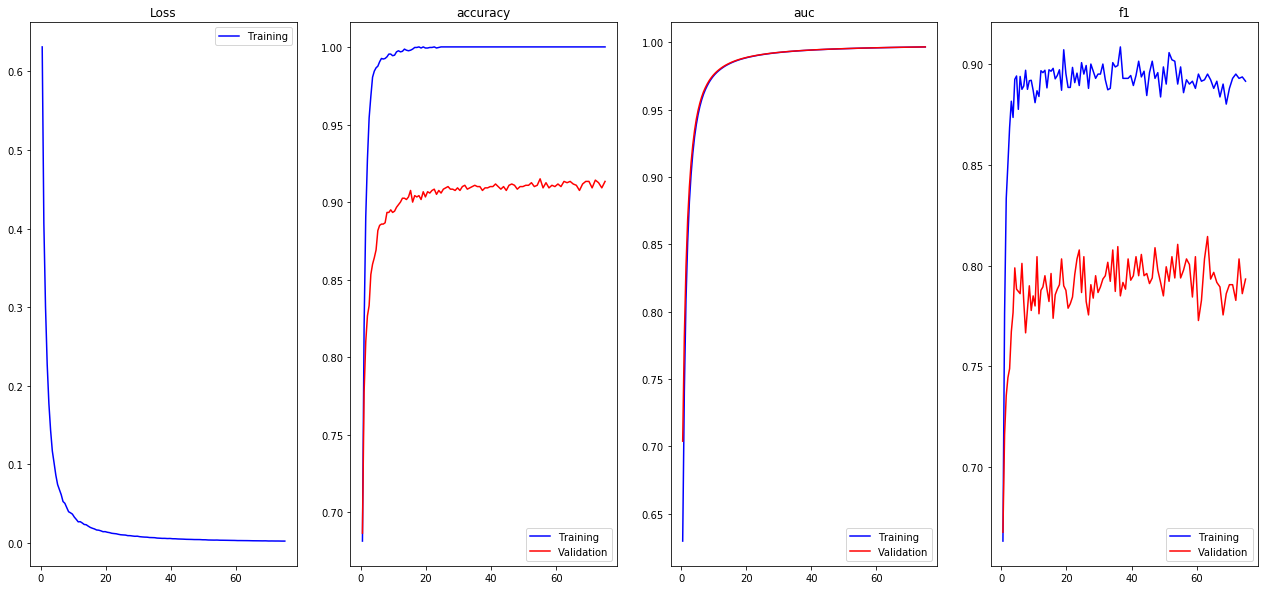

In [25]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-')#,
                 #epich, np.concatenate(
            #[mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training'])#, 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['acc'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_acc'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('accuracy')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['auc'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_auc'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('auc')

    _ = ax4.plot(epich, np.concatenate(
        [mh.history['f1'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_f1'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('f1')
    
show_loss(loss_history)

In [23]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(X_train)/BATCH_SIZE, 
                             epochs = 50,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(X_test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/50
7319/7319 [==============================] - 1983s 271ms/step - loss: 6.0294 - acc: 0.6218 - auc: 0.4991 - f1: 0.6995 - recall: 0.8549 - minC: 0.6113 - val_loss: 7.1415 - val_acc: 0.5520 - val_auc: 0.4999 - val_f1: 0.6345 - val_recall: 0.7993 - val_minC: 0.6952

Epoch 00001: val_minC improved from inf to 0.69524, saving model to DensNet121_test_weeekand_40%test.h5
Epoch 2/50
7319/7319 [==============================] - 1967s 269ms/step - loss: 5.6976 - acc: 0.6424 - auc: 0.5002 - f1: 0.7087 - recall: 0.8572 - minC: 0.5853 - val_loss: 0.0631 - val_acc: 0.9956 - val_auc: 0.5642 - val_f1: 0.8015 - val_recall: 0.8032 - val_minC: 0.0071

Epoch 00002: val_minC improved from 0.69524 to 0.00706, saving model to DensNet121_test_weeekand_40%test.h5
Epoch 3/50
7319/7319 [==============================] - 1950s 266ms/step - loss: 0.4041 - acc: 0.9747 - auc: 0.6549 - f1: 0.8500 - recall: 0.8609 - minC: 0.0417 - val_loss: 0.0602 - val_acc: 0.9960 - val_auc: 0.7140 - val_f1: 0.7924 - val_r

KeyboardInterrupt: 

In [86]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(X_train)/BATCH_SIZE, 
                             epochs = 50,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(X_test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/50
11157/11156 [==============================] - 2678s 240ms/step - loss: 5.4095 - acc: 0.6600 - auc: 0.7209 - f1: 0.7000 - recall: 0.8352 - minC: 0.5675 - val_loss: 7.1424 - val_acc: 0.5520 - val_auc: 0.5764 - val_f1: 0.6309 - val_recall: 0.7888 - val_minC: 0.6848

Epoch 00001: val_minC improved from inf to 0.68480, saving model to DensNet121_test_weeekand.h5
Epoch 2/50
11157/11156 [==============================] - 2765s 248ms/step - loss: 4.9319 - acc: 0.6903 - auc: 0.5593 - f1: 0.7111 - recall: 0.8327 - minC: 0.5185 - val_loss: 9.9447e-05 - val_acc: 1.0000 - val_auc: 0.6004 - val_f1: 0.8176 - val_recall: 0.8176 - val_minC: 0.0000e+00

Epoch 00002: val_minC improved from 0.68480 to 0.00000, saving model to DensNet121_test_weeekand.h5
Epoch 3/50
11157/11156 [==============================] - 2683s 241ms/step - loss: 0.2749 - acc: 0.9820 - auc: 0.6728 - f1: 0.8269 - recall: 0.8328 - minC: 0.1089 - val_loss: 1.6082e-04 - val_acc: 1.0000 - val_auc: 0.7282 - val_f1: 0.8096 - val

11157/11156 [==============================] - 2674s 240ms/step - loss: 0.2665 - acc: 0.9833 - auc: 0.9485 - f1: 0.8305 - recall: 0.8372 - minC: 0.0268 - val_loss: 1.0564e-05 - val_acc: 1.0000 - val_auc: 0.9491 - val_f1: 0.8304 - val_recall: 0.8304 - val_minC: 0.0000e+00

Epoch 00024: val_minC did not improve from 0.00000
Epoch 25/50
11157/11156 [==============================] - 2675s 240ms/step - loss: 0.2708 - acc: 0.9830 - auc: 0.9498 - f1: 0.8286 - recall: 0.8353 - minC: 0.0270 - val_loss: 1.0563e-05 - val_acc: 1.0000 - val_auc: 0.9504 - val_f1: 0.7952 - val_recall: 0.7952 - val_minC: 0.0000e+00

Epoch 00025: val_minC did not improve from 0.00000
Epoch 26/50
11157/11156 [==============================] - 2675s 240ms/step - loss: 0.2679 - acc: 0.9832 - auc: 0.9510 - f1: 0.8287 - recall: 0.8350 - minC: 0.0263 - val_loss: 1.0563e-05 - val_acc: 1.0000 - val_auc: 0.9515 - val_f1: 0.8224 - val_recall: 0.8224 - val_minC: 0.0000e+00

Epoch 00026: val_minC did not improve from 0.00000

Epo

KeyboardInterrupt: 

In [56]:
loss_history = [model_final.fit_generator(my_gen(train_gen), 
                             steps_per_epoch = len(X_train)/BATCH_SIZE, 
                             epochs = 1,
                             validation_data = my_gen(val_gen),
                             validation_steps = len(X_test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/1
11157/11156 [==============================] - 2595s 233ms/step - loss: 6.2284 - acc: 0.6090 - auc: 0.4996 - f1: 0.6812 - recall: 0.8367 - minC: 0.6473 - val_loss: 6.9806e-04 - val_acc: 1.0000 - val_auc: 0.5299 - val_f1: 0.8016 - val_recall: 0.8016 - val_minC: 0.0000e+00

Epoch 00001: val_minC improved from inf to 0.00000, saving model to DensNet121_test.h5


Exception ignored in: <generator object my_gen at 0x7fad9b2fe2b0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object my_gen at 0x7fad9b3e5d58>
RuntimeError: generator ignored GeneratorExit


In [69]:
from keras.preprocessing import image
ans = []
cnt = 0
for img_path in glob.glob('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/*.jpg'):
    
    try:
        img = image.load_img(img_path, target_size=(800, 800))
        #img = image.load_img(img_path)
        #img = cv2.resize(get_head(image.img_to_array(img)), (800, 800), cv2.INTER_NEAREST)/255.0
        img = image.img_to_array(img)/255.0
        #img = cv2.resize(get_head(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), (800, 800), cv2.INTER_NEAREST)/255.0
        arr = np.array([img])
        res = model_final.predict(arr)
        print('###', img_path)
        print(res[0][0])
        
        ans.append(res[0][0])
    except Exception:
        print(img_path)

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_07_020.jpg
5.98381e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/131_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/194_video_07_004.jpg
0.99686
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/78_video_05_003.jpg
6.01702e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/44_video_08_038.jpg
1.31449e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_05_002.jpg
5.3091e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/99_video_08_040.jpg
1.18128e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/90_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_da

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/100_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/93_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/71_video_05_008.jpg
4.48597e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/292_video_07_021.jpg
5.98448e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_07_020.jpg
2.77583e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_04_005.jpg
2.45641e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/192_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/254_video_05_001.jpg
2.48825e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/291_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_04_008.jpg
1.24954e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_07_020.jpg
5.39735e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/34_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/171_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/172_video_05_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/222_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/248_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/75_video_01_006.jpg
7.59855e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/237_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/297_video_08_030.jpg
2.72282e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/257_video_05_006.jpg
2.15683e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/161_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/43_video_05_008.jpg
2.31727e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/170_video_05_010.jpg
3.62795e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/168_video_05_008.jpg
9.48204e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/100_video_04_008.jpg
2.99062e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/79_video_08_040.jpg
3.90111e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/273_video_07_020.jpg
1.578e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/o

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/351_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/20_video_01_006.jpg
5.72008e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/237_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/485_video_04_005.jpg
6.54046e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/181_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/240_video_05_003.jpg
0.753828
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/68_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_colle

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/338_video_07_020.jpg
5.82281e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/66_video_07_021.jpg
0.00703591
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/341_video_07_021.jpg
1.95893e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/405_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_05_010.jpg
1.95293e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_07_021.jpg
0.000106062
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_05_004.jpg
2.89975e-05
### /home/neuralbee/workspace/anti_spoof_detection/o

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/94_video_04_005.jpg
3.1766e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/38_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/93_video_08_040.jpg
1.80641e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/90_video_05_003.jpg
0.25659
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/263_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/195_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_07_021.jpg
0.00757337
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/109_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/315_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/100_video_07_021.jpg
0.38054
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/199_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/646_video_03_003.jpg
4.24999e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/28_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/334_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_05_004.jpg
0.000348737
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_colle

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_05_004.jpg
0.0295198
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/343_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/76_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/23_video_04_001.jpg
1.58243e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/78_video_05_008.jpg
3.02014e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_07_020.jpg
3.47846e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/310_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_08_033.jpg
5.77677e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/5_video_07_004.jpg
4.51792e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/175_video_05_004.jpg
1.75499e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/232_video_08_039.jpg
2.42188e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_07_004.jpg
0.97691
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_05_001.jpg
6.92552e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/46_video_08_038.jpg
1.09018e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_08_030.jpg
7.93735e-37
### /home/neuralbee/workspace/anti_spoo

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/76_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/376_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/95_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/106_video_05_010.jpg
1.27038e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/158_video_05_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/469_video_04_005.jpg
2.56615e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/79_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/427_video_04_005.jpg
7.04087e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/167_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/59_video_05_004.jpg
5.30535e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/194_video_05_001.jpg
1.5319e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_04_008.jpg
1.53898e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/262_video_05_010.jpg
4.68778e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/447_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/140_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/271_video_05_003.jpg
0.6959
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/176_video_07_021.jpg
0.000662087
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/117_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/346_video_08_038.jpg
2.22277e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/381_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/212_video_04_005.jpg
0.99999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_05_003.jpg
0.998723
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/43_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_05_003.jpg
0.0281216
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/155_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/215_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/313_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_05_003.jpg
0.00147633
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/98_video_07_020.jpg
1.32986e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/178_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_col

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/103_video_01_006.jpg
6.67073e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/104_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/257_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/294_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/293_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/1

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/74_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/159_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/258_video_08_033.jpg
7.58664e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/409_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/227_video_05_003.jpg
0.949965
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_03_005.jpg
5.55738e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_col

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/357_video_08_038.jpg
3.38905e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/15_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/133_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/87_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_04_005.jpg
2.61851e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_05_004.jpg
3.73308e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/283_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/554_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/257_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/280_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/330_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/50_video_07_021.jpg
0.00863261
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/218_video_07_001.jpg
0.997907
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/242_video_03_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_04_005.jpg
4.86391e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/286_video_03_005.jpg
1.73403e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/343_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/110_video_03_005.jpg
4.21502e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/39_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_05_002.jpg
1.57258e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/338_video_08_038.jpg
6.12097e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/290_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_05_001.jpg
2.31894e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/309_video_05_001.jpg
2.06733e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/294_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_05_001.jpg
1.37897e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/216_video_05_008.jpg
3.10126e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/122_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/240_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/image

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/34_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/379_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/142_video_04_008.jpg
0.000171244
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/18_video_05_004.jpg
1.27787e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/207_video_08_038.jpg
3.28693e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/56_video_05_006.jpg
3.23373e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/86_video_04_005.jpg
1.18016e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/187_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/173_video_07_003.jpg
3.31835e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/81_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_07_004.jpg
0.278736
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/324_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimo

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_05_010.jpg
3.51986e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_05_002.jpg
2.99552e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/314_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/227_video_07_004.jpg
0.0149404
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/237_video_05_002.jpg
7.89402e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/44_video_05_008.jpg
4.70438e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/178_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_07_004.jpg
0.00194831
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/223_video_05_003.jpg
0.870021
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_05_002.jpg
3.49435e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/263_video_05_008.jpg
3.12632e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/59_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/353_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/212_video_07_001.jpg
0.968359
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_04_001.jpg
2.17213e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_08_038.jpg
5.01197e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/224_video_05_001.jpg
2.90749e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/56_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/14_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/74_video_04_001.jpg
3.25775e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/172_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/12_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/412_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/r

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_05_004.jpg
5.71422e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/217_video_07_004.jpg
0.0282089
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/549_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/140_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/143_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/170_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/372_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/49_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/161_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/286_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/54_video_04_001.jpg
6.43148e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/357_video_04_005.jpg
4.83041e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/179_video_05_010.jpg
1.55657e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/209_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/70_video_05_001.jpg
1.46211e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/130_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/93_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/13_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/279_video_05_002.jpg
3.25896e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/334_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_03_001.jpg
0.99963
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/53_video_04_001.jpg
9.31323e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/318_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_05_004.jpg
3.01103e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/72_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/104_video_05_004.jpg
5.25806e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimo

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/24_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/106_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/25_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/24_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_04_008.jpg
3.35077e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_07_003.jpg
5.47184e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/26_video_07_004.jpg
1.14081e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_colle

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/28_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/191_video_07_020.jpg
1.74165e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_05_002.jpg
4.01127e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/333_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/262_video_05_004.jpg
7.11171e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/68_video_03_005.jpg
3.006e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/335_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/275_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/4_video_07_003.jpg
0.0246585
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/128_video_05_001.jpg
1.09148e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/266_video_08_039.jpg
2.35969e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/246_video_08_038.jpg
5.03872e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/237_video_08_039.jpg
1.96241e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/333_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/104_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/285_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/300_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/613_video_03_003.jpg
1.30631e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/75_video_04_005.jpg
2.26392e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/82_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/232_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_03_005.jpg
5.93058e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/196_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/287_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/16_video_04_005.jpg
2.64298e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_05_006.jpg
1.4362e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/299_video_07_021.jpg
5.05085e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/72_video_07_020.jpg
3.94836e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/185_video_08_033.jpg
9.833e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/112_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_07_020.jpg
1.77092e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_05_003.jpg
0.850019
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_07_021.jpg
0.000837172
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/30_video_07_004.jpg
0.00164877
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/340_video_05_003.jpg
0.931646
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/379_video_07_020.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/299_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_05_008.jpg
1.00519e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/320_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/380_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_05_003.jpg
0.999994
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/298_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/69_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/278_video_03_005.jpg
1.33723e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/75_video_08_038.jpg
8.75965e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_05_001.jpg
1.3668e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/283_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/306_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/91_video_07_004.jpg
0.916232
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/167_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_03_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/214_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/94_video_05_003.jpg
0.00484317
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_05_008.jpg
3.03476e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/144_video_04_001.jpg
3.2209e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/117_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/204_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/66_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/332_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/271_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_05_003.jpg
0.867885
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_03_005.jpg
4.52869e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/46_video_03_005.jpg
1.67804e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/280_video_08_033.jpg
7.09196e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/122_video_07_020.jpg
5.87188e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/277_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/6_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/304_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/303_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/208_video_05_002.jpg
3.14093e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_05_010.jpg
4.24616e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/97_video_05_008.jpg
2.20682e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/329_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/365_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/174_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/25_video_08_039.jpg
3.78048e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/365_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_04_008.jpg
1.88428e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/114_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_04_001.jpg
2.61225e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/118_video_05_003.jpg
0.0167144
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/353_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/424_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/301_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_05_003.jpg
0.98467
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/125_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/213_video_08_038.jpg
9.48454e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_08_030.jpg
7.64693e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_07_004.jpg
0.138674
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/194_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/57_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/300_video_08_030.jpg
5.43701e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/432_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/321_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/142_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_col

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/137_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/99_video_07_003.jpg
0.00600866
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/216_video_07_004.jpg
0.113037
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/103_video_07_020.jpg
1.00127e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/286_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_01_006.jpg
4.2978e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_05_001.jpg
4.54807e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/ima

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/99_video_05_010.jpg
3.06769e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/263_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/615_video_03_003.jpg
6.16819e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/59_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_04_005.jpg
0.0486622
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/167_video_05_010.jpg
1.65004e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/174_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/44_video_04_005.jpg
8.19827e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/279_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/91_video_05_002.jpg
3.4843e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/285_video_07_004.jpg
0.0461112
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/573_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/396_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/242_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/87_video_07_020.jpg
1.73063e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_04_008.jpg
4.82373e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/38_video_07_021.jpg
0.907357
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_04_001.jpg
3.60517e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/70_video_07_003.jpg
0.00080001
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/271_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/ima

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/336_video_07_020.jpg
1.79422e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_05_002.jpg
7.96533e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/449_video_04_005.jpg
5.55674e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/341_video_08_038.jpg
1.0063e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_05_002.jpg
8.54797e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/49_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/158_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/185_video_05_010.jpg
9.94122e-08
### /home/neuralbee/workspace/anti_spoof_detection

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/270_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/152_video_05_004.jpg
5.57304e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/546_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/33_video_03_005.jpg
2.22665e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/216_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/216_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/185_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/26_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/232_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/298_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/224_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/152_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/93_video_04_001.jpg
2.25955e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/21_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/73_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/104_video_03_005.jpg
5.37196e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/266_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/102_video_04_001.jpg
1.49461e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_04_005.jpg
2.06522e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/110_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/497_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/128_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/414_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/282_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/341_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/336_video_07_021.jpg
3.39566e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_08_039.jpg
1.47406e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/262_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_08_029.jpg
1.05806e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_08_029.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/240_video_03_005.jpg
1.86172e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/109_video_05_010.jpg
5.19645e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/179_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/358_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/142_video_01_008.jpg
8.00105e-34
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_07_004.jpg
0.454332
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_05_008.jpg
2.13182e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/18_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/9_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/166_video_07_020.jpg
7.28898e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/266_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/177_video_05_008.jpg
7.23139e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/190_video_05_003.jpg
0.999988
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/29_video_01_006.jpg
1.65072e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/361_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/228_video_07_020.jpg
6.77576e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/99_video_03_005.jpg
2.88837e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/i

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/231_video_07_020.jpg
3.16847e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/403_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/224_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/84_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/271_video_08_038.jpg
0.643017
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_04_001.jpg
2.8857e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_colle

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/327_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/173_video_05_001.jpg
6.0033e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_04_005.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/156_video_04_005.jpg
5.92566e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/191_video_04_005.jpg
0.0062271
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/38_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_05_010.jpg
1.30604e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/308_video_07_020.jpg
2.2433e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/251_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/137_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_05_006.jpg
4.79396e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/92_video_08_038.jpg
2.69727e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_05_006.jpg
2.60259e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_07_004.jpg
0.475666
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/im

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/316_video_04_001.jpg
7.03311e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/269_video_08_038.jpg
0.999866
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/274_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/282_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/r

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/624_video_03_003.jpg
0.137497
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/364_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/72_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/356_video_08_038.jpg
1.73093e-34
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/179_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/215_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/57_video_04_005.jpg
3.47964e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/215_video_08_038.jpg
1.15155e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/240_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/376_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_08_033.jpg
3.45343e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/51_video_05_004.jpg
2.80152e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/292_video_05_004.jpg
2.96716e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_07_021.jpg
0.917072
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/90_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/62_video_04_005.jpg
0.508469
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_05_010.jpg
4.71412e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/89_video_03_005.jpg
3.82032e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/264_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/158_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/53_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_01_008.jpg
6.67069e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/170_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimo

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/270_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/157_video_05_010.jpg
3.54404e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/187_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/481_video_04_005.jpg
5.14646e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/344_video_08_038.jpg
9.27848e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/166_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_07_004.jpg
0.338746
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/128_video_04_001.jpg
7.90764e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_04_001.jpg
3.45643e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/341_video_04_005.jpg
1.43436e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/355_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/268_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/269_video_08_039.jpg
4.89568e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/111_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/132_video_05_010.jpg
3.90135e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/321_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/351_video_05_003.jpg
0.748332
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/265_video_07_020.jpg
6.35277e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/407_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/291_video_04_001.jpg
3.16771e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/182_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/124_video_05_004.jpg
2.02972e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_04_008.jpg
2.54071e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/387_video_07_020.jpg
2.15265e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/159_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/192_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/479_video_04_005.jpg
2.26625e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/165_video_07_003.jpg
5.79509e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/87_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/177_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_07_021.jpg
0.000477466
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/306_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/43_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/476_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/258_video_05_002.jpg
2.35512e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/233_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/323_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/116_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/212_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/1

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_04_001.jpg
1.47325e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/153_video_03_005.jpg
5.39136e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/305_video_07_020.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_05_006.jpg
4.45791e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/33_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/79_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/13_video_07_004.jpg
0.268283
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/246_video_07_004.jpg
0.00010781
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/212_video_05_008.jpg
3.61375e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/143_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_05_002.jpg
2.43086e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/174_video_03_005.jpg
2.39344e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/256_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_03_002.jpg
2.41998e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/275_video_07_021.jpg
1.32988e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/58_video_07_021.jpg
0.000257352
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/157_video_05_003.jpg
0.999997
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_04_008.jpg
1.49442e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/70_video_05_004.jpg
3.36135e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_07_003.jpg
0.0136593
### /home/neuralbee/workspace/anti_spoof_detection

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/385_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/141_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/208_video_04_008.jpg
1.00472e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/225_video_04_005.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/31_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/236_video_03_002.jpg
1.05332e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/243_video_05_002.jpg
5.88214e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/319_video_05_010.jpg
1.30702e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/image

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_07_003.jpg
0.163797
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/119_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/354_video_04_005.jpg
9.71285e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/166_video_07_004.jpg
0.996399
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/105_video_05_001.jpg
4.13635e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/179_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/62_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/172_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/169_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/82_video_04_005.jpg
1.57534e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/191_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/329_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/207_video_07_003.jpg
0.00171268
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/254_video_04_008.jpg
1.63419e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/187_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/71_video_07_021.jpg
0.00712608
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_01_004.jpg
1.05353e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/177_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/211_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/125_video_05_006.jpg
2.56381e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/95_video_05_003.jpg
0.00628765
### /home/neuralbee/workspace/anti_spoof_detection/our_data/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_08_038.jpg
2.85122e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/144_video_05_004.jpg
6.7272e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/219_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/95_video_08_040.jpg
8.82512e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_05_003.jpg
0.924682
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/147_video_05_002.jpg
6.23495e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/i

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/231_video_04_008.jpg
1.78742e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/277_video_05_003.jpg
0.241091
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/98_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/229_video_08_033.jpg
1.59025e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_03_005.jpg
1.45791e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_01_006.jpg
2.19961e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/262_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/41_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/34_video_05_001.jpg
2.29108e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/261_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/21_video_04_008.jpg
3.58077e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/133_video_07_004.jpg
0.999997
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimo

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/9_video_03_002.jpg
5.43599e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/275_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/264_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/248_video_05_003.jpg
0.93349
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/62_video_01_006.jpg
3.07939e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/181_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collec

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/19_video_04_008.jpg
1.74461e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_05_006.jpg
2.66401e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/380_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_03_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/315_video_03_005.jpg
6.28008e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/14_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/381_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/117_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/81_video_03_002.jpg
4.30699e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/298_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/243_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/171_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/113_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_05_006.jpg
6.76194e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/246_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_01_008.jpg
6.50043e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/152_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_05_002.jpg
2.7373e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/333_video_07_021.jpg
1.73882e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/88_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/340_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_05_010.jpg
1.49794e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/34_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_colle

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/119_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_05_010.jpg
1.07934e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/333_video_05_003.jpg
0.719907
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/60_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/14_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/304_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/rea

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/70_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_05_003.jpg
0.19685
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/312_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/20_video_05_006.jpg
2.03399e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_04_005.jpg
0.993889
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/310_video_05_003.jpg
0.982381
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/473_video_04_005.jpg
1.30003e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_04_005.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/31_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/191_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/118_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/268_video_05_002.jpg
8.1139e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/78_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/343_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/117_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/128_video_05_008.jpg
6.39359e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/271_video_08_033.jpg
5.69595e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/330_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/315_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/94_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/322_video_05_003.jpg
0.95884
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/230_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/280_video_05_003.jpg
0.996031
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/188_video_03_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_04_005.jpg
0.157717
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/263_video_08_038.jpg
0.00829883
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/251_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_08_029.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/161_video_05_006.jpg
2.74353e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_07_001.jpg
0.99399
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/31_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_07_020.jpg
1.74408e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/289_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/31_video_05_003.jpg
0.999965
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/395_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/148_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/413_video_04_005.jpg
8.53566e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_04_001.jpg
1.28815e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/71_video_01_006.jpg
1.53873e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/97_video_08_038.jpg
4.22626e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/158_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/255_video_04_005.jpg
0.992892
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/141_video_04_005.jpg
4.77861e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/625_video_03_003.jpg
0.0253735
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/294_video_04_001.jpg
9.89507e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/222_video_07_004.jpg
0.069465
### /home/neuralbee/workspace/anti_spoof_detection

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/218_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/433_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_04_008.jpg
0.000304888
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/121_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/228_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/110_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/50_video_05_002.jpg
1.19394e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/23_video_07_004.jpg
1.25443e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/204_video_05_006.jpg
1.35545e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/6_video_03_001.jpg
1.9698e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/472_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/76_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/264_video_07_004.jpg
0.170897
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/38_video_03_005.jpg
1.28314e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/image

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/97_video_04_008.jpg
3.81145e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/268_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/346_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/273_video_08_039.jpg
2.4636e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/366_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/410_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_05_008.jpg
2.05642e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_07_004.jpg
0.0664357
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_05_001.jpg
6.38582e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/276_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/173_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/26_video_07_003.jpg
0.136422
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/354_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_01_008.jpg
5.01143e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/ima

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/191_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/127_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/445_video_04_005.jpg
8.30133e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/335_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/87_video_07_003.jpg
0.00614832
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/278_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/122_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_07_004.jpg
0.999762
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/231_video_05_004.jpg
0.00353348
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/275_video_05_002.jpg
7.80786e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/296_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/91_video_08_039.jpg
7.62473e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/17_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/219_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/192_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_04_005.jpg
0.994887
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/115_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/79_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/159_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/214_v

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/56_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/233_video_03_002.jpg
6.51472e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/47_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/16_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/227_video_07_020.jpg
2.61426e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/225_video_05_010.jpg
8.16472e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/36_video_05_010.jpg
1.54484e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/15_video_05_010.jpg
2.53936e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/i

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/115_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/114_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/190_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/182_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/230_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/1_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/85_video_05_001.jpg
1.84882e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/303_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/181

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/5_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/24_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/32_video_04_008.jpg
8.25696e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_05_006.jpg
1.61514e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/181_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/316_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/70_video_03_001.jpg
0.977676
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/31_video_05_010.jpg
9.88444e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/97_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/9_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_07_004.jpg
0.123068
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/339_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/270_video_08_038.jpg
0.910059
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_08_038.jpg
7.47507e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/320_video_03_005.jpg
7.2767e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_co

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/182_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/20_video_05_010.jpg
5.03515e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/23_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/130_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/418_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_05_010.jpg
8.77739e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/368_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/130_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_05_008.jpg
8.11766e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/131_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/233_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/311_video_05_001.jpg
2.2288e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/425_video_04_005.jpg
2.99846e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/302_video_03_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/142_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/427_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/84_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/151_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/127_video

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/258_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/346_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/111_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_05_006.jpg
4.27496e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/24_video_01_006.jpg
1.18719e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/213_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/394_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/281_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/54_video_07_003.jpg
2.94015e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/219_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_05_010.jpg
1.3246e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/82_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/51_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/165_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/364_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/114_video_04_005.jpg
0.0300419
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/287_video_07_020.jpg
1.73779e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_07_021.jpg
0.000756532
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_col

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/112_video_08_038.jpg
4.87875e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/13_video_04_005.jpg
3.53948e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/374_video_03_005.jpg
3.8639e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/278_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_05_002.jpg
3.25164e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_05_003.jpg
0.986875
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/73_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/imag

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/57_video_08_038.jpg
1.73195e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/9_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/274_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/47_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_05_008.jpg
1.5275e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/253_video_08_033.jpg
2.56046e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collec

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/115_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/35_video_07_004.jpg
2.11085e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/146_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/154_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/364_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/6_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/157_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/124_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/320_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/242_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/348_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_08_040.jpg
4.53089e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/255_video_08_030.jpg
2.02726e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/67_video_05_002.jpg
1.42452e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_05_003.jpg
0.0125305
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/238_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/252_video_05_010.jpg
2.89212e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/290_video_07_021.jpg
8.02819e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/315_video_05_003.jpg
0.785756
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/361_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/82_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/199_video_04_005.jpg
0.000479455
### /home/neuralbee/workspace/anti_spoof_detection/our_data/im

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/155_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_08_038.jpg
8.12144e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/206_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/447_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/101_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/176_video_05_008.jpg
3.65978e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/45_video_08_039.jpg
2.6656e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/217_video_03_005.jpg
7.09957e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/400_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/106_video_05_003.jpg
0.00136589
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/3_video_08_038.jpg
1.47322e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/131_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/i

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_04_008.jpg
3.37957e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/217_video_08_038.jpg
5.80829e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/21_video_03_002.jpg
3.50064e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/107_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/46_video_04_001.jpg
2.67216e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/83_video_05_004.jpg
1.89829e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/76_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/261_video_08_030.jpg
1.2875e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/245_video_07_001.jpg
0.999999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_05_004.jpg
4.1324e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/85_video_07_004.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/15_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/109_video_01_008.jpg
6.44959e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/94_video_07_021.jpg
0.983323
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/219_video_08_038.jpg
1.545e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/295_video_07_020.jpg
3.01679e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/3_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/91_video_08_038.jpg
1.42117e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/291_video_05_001.jpg
1.84057e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/278_video_08_038.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/49_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/219_video_05_006.jpg
3.24365e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/im

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/148_video_04_005.jpg
7.99423e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/68_video_07_003.jpg
0.302959
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/58_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/233_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/222_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/230_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/140_video_05_002.jpg
4.45183e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/313_video_07_021.jpg
5.02154e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_04_008.jpg
0.0323074
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_01_006.jpg
5.0116e-37
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/92_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/175_video_03_005.jpg
6.83646e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/171_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_03_005.jpg
3.11746e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/173_video_08_029.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/384_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/124_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/345_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/144_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/135_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/352_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/39_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/172_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/372_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/82_video_05_004.jpg
5.22013e-16
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/49_video_05_006.jpg
1.06815e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/292_video_05_006.jpg
3.31166e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/111_video_05_004.jpg
1.87752e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_07_004.jpg
0.232498
### /home/neuralbee/workspace/anti_spoof_detection/our_data/im

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/123_video_05_010.jpg
1.61689e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/568_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/341_video_05_001.jpg
2.03617e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/424_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/353_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/103_video_05_003.jpg
7.15741e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/405_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/225_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_04_008.jpg
1.85948e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/249_video_04_005.jpg
0.999998
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/98_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/416_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/102_video_07_004.jpg
0.271278
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/148_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/236_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/83_video_05_008.jpg
6.32418e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_07_003.jpg
2.9164e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/87_video_08_040.jpg
1.07147e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/73_video_05_006.jpg
5.75113e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/221_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/130_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/220_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/189_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/72_video_01_006.jpg
4.58728e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/384_video_04_005.jpg
2.46909e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/114_video_04_001.jpg
3.97517e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/307_video_07_020.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/166_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_08_030.jpg
2.64658e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/69_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/27_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/100_video_08_039.jpg
3.67654e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/116_video_04_005.jpg
5.35961e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/43_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_08_029.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/127_video_08_030.jpg
2.74671e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/217_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_07_001.jpg
0.999999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/76_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/313_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/150_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/33_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/144_video_01_006.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/221_video_03_005.jpg
7.61798e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/416_video_01_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/151_video_08_030.jpg
2.28777e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/85_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/186_video_05_006.jpg
2.99222e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/255_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/33_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/288_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/397_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/168_video_07_020.jpg
6.02142e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_05_003.jpg
0.00102944
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/50_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/362_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/113_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/20_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_07_021.jpg
0.018498
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/73_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/232_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/21_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/156_video_01_008.jpg
1.05483e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/207_video_07_001.jpg
0.999997
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/244_video_07_004.jpg
0.00100907
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/152_video_03_005.jpg
1.24284e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/501_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/251_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/231_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/256_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/85_video_07_021.jpg
0.994891
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/337_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/88_video_05_002.jpg
3.06972e-38
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/274_video_03_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/202_video_03_005.jpg
2.74516e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/209_video_05_006.jpg
8.67372e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_di

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/17_video_03_001.jpg
0.000623212
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/136_video_08_030.jpg
4.81529e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/329_video_07_020.jpg
1.54725e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/66_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/231_video_08_030.jpg
9.52638e-34
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/467_video_04_005.jpg
1.11755e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/216_video_08_039.jpg
3.65399e-32
### /home/neuralbee/workspace/anti_spoof_detection/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/90_video_04_001.jpg
1.73413e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/177_video_04_005.jpg
0.999882
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/261_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/125_video_07_004.jpg
0.999999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/200_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_01_008.jpg
3.24372e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/2_video_05_010.jpg
6.70471e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/239_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/image

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/390_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/222_video_05_001.jpg
3.72138e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/119_video_04_008.jpg
2.58233e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/53_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/184_video_05_004.jpg
7.93969e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/162_video_03_001.jpg
0.28357
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/79_video_05_010.jpg
3.57357e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/im

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/52_video_05_002.jpg
1.50105e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/323_video_05_001.jpg
1.80058e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_05_001.jpg
1.05449e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/321_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_04_005.jpg
2.16691e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/112_video_03_005.jpg
1.56348e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/210_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_dat

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/430_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/99_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/140_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_07_001.jpg
0.999999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_05_006.jpg
3.37074e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/413_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/re

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/75_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/237_video_08_040.jpg
2.78285e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/60_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_07_004.jpg
0.999597
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/80_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/265_video_08_030.jpg
1.0742e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/23_video_08_038.jpg
3.8999e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/15_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_c

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_08_038.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/25_video_05_003.jpg
0.896552
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/58_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/91_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/193_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/165_video_03_001.jpg
2.12297e-10
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/269_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/421_video_04_005.jpg
3.98292e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/56_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/107_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/285_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/198_video_05_002.jpg
3.29899e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/242_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/186_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_05_001.jpg
6.90616e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/140_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/190_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/175_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/145_video_08_029.jpg
1.77853e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/8_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/229_video_01_006.jpg
3.52806e-34
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/153_video_05_008.jpg
8.61642e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/4_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/49_video_05_001.jpg
1.43431e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/155_video_04_005.jpg
1.28876e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/292_video_07_020.jpg
3.51422e-26
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/264_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/53_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/273_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_coll

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/112_video_07_001.jpg
0.999999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/236_video_05_003.jpg
0.574724
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/267_video_05_010.jpg
8.27076e-08
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/148_video_05_004.jpg
4.08787e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/44_video_01_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/306_video_03_005.jpg
1.58033e-36
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/286_video_04_001.jpg
4.10858e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_05_002.jpg
3.84419e-29
### /home/neuralbee/workspace/anti_spoof_detecti

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/196_video_05_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/203_video_07_004.jpg
0.675396
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/98_video_08_030.jpg
1.15512e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/139_video_05_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/13_video_03_001.jpg
0.107934
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_07_020.jpg
1.35511e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/48_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/261_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/78_video_05_004.jpg
4.77861e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/40_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/241_video_07_003.jpg
0.989936
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/25_video_03_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/149_video_05_004.jpg
2.01146e-15
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collec

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/315_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/308_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/138_video_07_021.jpg
0.999324
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/1_video_07_020.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/58_video_07_003.jpg
7.70724e-07
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/320_video_05_003.jpg
0.763182
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/170_video_08_029.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/192_video_08_033.jpg
0.00153127
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/163_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/94_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/288_video_04_001.jpg
1.1771e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/186_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/333_video_08_038.jpg
3.8074e-33
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/170_video_07_020.jpg
3.36374e-11
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/174_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/629_video_03_003.jpg
6.94374e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/165_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/188_video_05_002.jpg
3.17178e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/413_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/221_video_05_004.jpg
0.000403476
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/229_video_05_008.jpg
2.35748e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/166_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/150_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/imag

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/134_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/60_video_03_001.jpg
0.997653
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/334_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/180_video_05_006.jpg
7.731e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_07_021.jpg
0.99999
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/7_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/19_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/162_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/re

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/56_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/120_video_04_005.jpg
0.997678
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/130_video_07_003.jpg
0.999995
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/377_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/506_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/34_video_04_005.jpg
1.41247e-19
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_07_021.jpg
0.000465188
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/288_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/66_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/145_video_05_008.jpg
1.37367e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/259_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/2_video_05_004.jpg
3.2009e-14
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/227_video_08_038.jpg
1.68199e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/290_video_03_004.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/118_video_03_005.jpg
5.52958e-34
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_d

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/160_video_07_003.jpg
3.18603e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/68_video_01_003.jpg
1.40708e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/101_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/108_video_07_021.jpg
5.80373e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/88_video_01_006.jpg
4.10337e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/141_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/230_video_05_004.jpg
0.0708892
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_04_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/22_video_05_001.jpg
5.81344e-17
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/107_video_04_001.jpg
3.88021e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/116_video_08_012.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/284_video_04_005.jpg
4.39137e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/129_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/26_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/63_video_05_001.jpg
6.41442e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_07_020.jpg
6.84613e-28
### /home/neuralbee/workspace/anti_spoof_detection/our_data

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/209_video_05_008.jpg
4.41136e-23
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/290_video_07_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/176_video_01_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/10_video_07_004.jpg
0.17027
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/168_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/509_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/18_video_07_020.jpg
4.25412e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/102_video_05_001.jpg
1.35998e-22
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dim

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/53_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_05_010.jpg
8.87722e-13
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/43_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/308_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/229_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/247_video_03_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/11_video_08_029.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/201_video_04_008.jpg
0.00569718
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/re

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/96_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/234_video_08_039.jpg
9.07642e-24
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/151_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/205_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/299_video_05_002.jpg
2.47742e-20
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/467_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/334_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/153_video_08_039.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/270_video_08_033.jpg
3.62617e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/249_video_05_002.jpg
3.81673e-12
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/169_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/370_video_04_005.jpg
1.39167e-31
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/44_video_05_004.jpg
1.57365e-18
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/37_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/126_video_01_008.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/106_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/217_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/107_video_03_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/350_video_08_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/90_video_04_008.jpg
1.08902e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/93_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/293_video_05_002.jpg
7.23927e-21
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/169_video_05_003.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/295_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/77_video_05_002.jpg
1.51267e-32
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/183_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/291_video_05_003.jpg
0.700199
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/25_video_04_008.jpg
2.0873e-30
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/9_video_07_021.jpg
2.8016e-06
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/260_video_05_001.jpg
1.78551e-27
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/372_video_08_040.jpg
1.21415e-35
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/21_video_05_008.jpg
8.96117e-16
### /home/neuralbee/workspace/anti_spoof_detection

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_01_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/323_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/155_video_07_021.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/163_video_04_005.jpg
2.23423e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/102_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/164_video_04_005.jpg
5.93852e-05
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/189_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/150_video_03_003.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collecte

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/188_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/106_video_08_002.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/64_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/212_video_08_030.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/61_video_03_001.jpg
0.977462
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/125_video_01_005.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/54_video_01_007.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/235_video_08_039.jpg
3.05165e-25
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/rea

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/306_video_05_010.jpg
1.03075e-09
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/185_video_08_011.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/121_video_07_001.jpg
1.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/363_video_08_033.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/55_video_04_001.jpg
2.33293e-29
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/258_video_02_001.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/287_video_05_003.jpg
0.954781
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/real/338_video_08_040.jpg
0.0
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_col

KeyboardInterrupt: 

In [70]:
ans = np.array(ans)

In [75]:
len(ans[ans > 0.99])

1298

In [71]:
ans.shape

(11683,)

In [27]:
loss_history = [model_final.fit_generator(train_gen, 
                             steps_per_epoch = len(X_train)/BATCH_SIZE, 
                             epochs = 50,
                             validation_data = val_gen,
                             validation_steps = len(X_test)/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/50
27385/27385 [==============================] - 4792s 175ms/step - loss: 2.8298 - acc: 0.8225 - auc: 0.4999 - f1: 0.8713 - recall: 0.9691 - minC: 0.3259 - val_loss: 2.8349 - val_acc: 0.8222 - val_auc: 0.5000 - val_f1: 0.8691 - val_recall: 0.9629 - val_minC: 0.3185

Epoch 00001: val_minC improved from inf to 0.31854, saving model to DensNet121.h5
Epoch 2/50
27385/27385 [==============================] - 4760s 174ms/step - loss: 2.8255 - acc: 0.8224 - auc: 0.5003 - f1: 0.8709 - recall: 0.9680 - minC: 0.3391 - val_loss: 2.8118 - val_acc: 0.8236 - val_auc: 0.5005 - val_f1: 0.8697 - val_recall: 0.9619 - val_minC: 0.3147

Epoch 00002: val_minC improved from 0.31854 to 0.31473, saving model to DensNet121.h5
Epoch 3/50
27385/27385 [==============================] - 4748s 173ms/step - loss: 0.5878 - acc: 0.9429 - auc: 0.5637 - f1: 0.9283 - recall: 0.9425 - minC: 0.5302 - val_loss: 0.9766 - val_acc: 0.8815 - val_auc: 0.6315 - val_f1: 0.8605 - val_recall: 0.8395 - val_minC: 2.4815

Epoc

KeyboardInterrupt: 

In [16]:
model_final = get_model(img_rows=img_rows, img_cols=img_cols)
# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001, decay=0.0001), metrics=['accuracy',auc,f1, recall, minC])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
model_final.fit_generator(
                generator=train_generator,
                steps_per_epoch=int(len(X_train) / BATCH_SIZE),
                validation_data=test_generator,
                validation_steps=int(len(X_test) / BATCH_SIZE),
                verbose=1,
                epochs=30,
                workers=5,
                use_multiprocessing=True,
            )

Epoch 1/30


/home/neuralbee/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


23062/23062 [==============================] - 5301s 230ms/step - loss: 0.9058 - acc: 0.8055 - auc: 0.5628 - f1: 0.8565 - recall: 0.9408 - minC: 0.8095 - val_loss: 1.0568 - val_acc: 0.7619 - val_auc: 0.5418 - val_f1: 0.8153 - val_recall: 0.8734 - val_minC: 1.9705
Epoch 2/30
23062/23062 [==============================] - 5261s 228ms/step - loss: 0.7984 - acc: 0.8197 - auc: 0.5405 - f1: 0.8682 - recall: 0.9624 - minC: 0.3870 - val_loss: 0.9298 - val_acc: 0.7749 - val_auc: 0.5409 - val_f1: 0.8277 - val_recall: 0.8990 - val_minC: 1.5338
Epoch 3/30
23062/23062 [==============================] - 5259s 228ms/step - loss: 0.7450 - acc: 0.8293 - auc: 0.5403 - f1: 0.8772 - recall: 0.9719 - minC: 0.3390 - val_loss: 0.9835 - val_acc: 0.7454 - val_auc: 0.5399 - val_f1: 0.7988 - val_recall: 0.8517 - val_minC: 2.4319
Epoch 4/30
23062/23062 [==============================] - 5260s 228ms/step - loss: 0.7184 - acc: 0.8249 - auc: 0.5403 - f1: 0.8732 - recall: 0.9693 - minC: 0.3366 - val_loss: 0.8380 - va

In [16]:
len(X_test)

3131

In [17]:
y_test

[1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


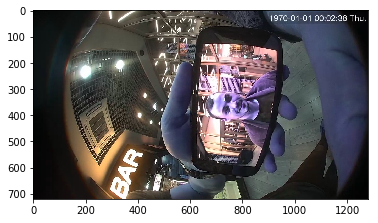

In [21]:
plt.imshow(cv2.imread(X_test[0]))

In [20]:
X_test[0]

'/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/163_video_04_010.jpg'

In [17]:
bad = []
for i, file in enumerate(X_test):
    if y_test[i] == 1:
        try:
            ans = loaded_model.predict(np.array([cv2.resize(cv2.imread(file), (224, 224))/255.0]))
            if ans[0][0] < 0.5:
                bad.append(file)
                print(file)
                print(ans[0][0])
        except Exception:
            print('err', file)
        
        
    

/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/267_video_05_012.jpg
0.158741
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/112_video_05_007.jpg
0.296336
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/92_video_01_023.jpg
0.483508
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/320_video_05_007.jpg
0.372943
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/223_video_05_007.jpg
0.477506
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/36_video_01_023.jpg
0.35184
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/342_video_04_003.jpg
0.358614
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/348_video_04_003.jpg
0.345805
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/41_video_05_013.jpg
0.491611
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/39_video_04_007.jpg
0.494354
/home/neuralbee

/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/168_video_05_011.jpg
0.0194041
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/197_video_05_012.jpg
0.0370443
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/208_video_05_012.jpg
0.0547857
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/193_video_05_011.jpg
0.00997368
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/115_video_05_007.jpg
0.277619
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/37_video_05_012.jpg
0.139483
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/311_video_05_013.jpg
0.494708
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/20_video_05_011.jpg
0.00439078
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/167_video_05_011.jpg
0.0383159
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/82_video_05_007.jpg
0.289199
/home

/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/78_video_05_012.jpg
0.166234
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/197_video_05_011.jpg
0.0152883
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/165_video_05_011.jpg
0.0250577
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/6_video_05_007.jpg
0.292682
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/305_video_04_003.jpg
0.412957
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/48_video_05_012.jpg
0.0543825
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/104_video_05_012.jpg
0.243249
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/216_video_05_012.jpg
0.0289219
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/17_video_05_012.jpg
0.238132
/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/19_video_05_012.jpg
0.222276
/home/neural

In [20]:
bad

['/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/267_video_05_012.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/112_video_05_007.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/92_video_01_023.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/320_video_05_007.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/223_video_05_007.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/36_video_01_023.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/342_video_04_003.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/348_video_04_003.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/41_video_05_013.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images/spoof/39_video_04_007.jpg',
 '/home/neuralbee/workspace/anti_spoof_detection/our_data/images

In [21]:
from shutil import copyfile


In [22]:
for x in bad:
    copyfile(x, '/home/neuralbee/workspace/anti_spoof_detection/errors/'+x.split('/')[-1])

In [18]:
len(bad)

224

In [19]:
len(y_test)

3131

In [25]:
model_final.predict(np.array([cv2.resize(cv2.imread(X_test[0]), (224, 224))/255.0]))

array([[ 0.97001612]], dtype=float32)

In [26]:
model_json = model_final.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_final.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001, decay=0.0001), metrics=['accuracy',auc,f1, recall])

Loaded model from disk


In [28]:
from keras.models import load_model

model_final.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model_final  # deletes the existing model



In [ ]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(pred, axis=-1)))